In [73]:
import sys
sys.path.append('../lib/python/')

import moving_edges

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from tabulate import tabulate

from pathlib import Path

from scipy.stats import ttest_1samp, ttest_ind, linregress
from statsmodels.stats.multitest import multipletests
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

import seaborn as sns
import os
save_filepath = os.getcwd() + "/../figures/"

plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [74]:
stimulus_df = pd.read_csv(r'../tiled_edge_stimuli.csv')

stimulus_df['Shape'] = stimulus_df['Shape'].map(lambda shape: list(map(int, shape.split(',')))) #convert shape to int list
stimulus_df['stimulus code'] = stimulus_df['stimulus code'].map(lambda code: list(map(int, code.strip('[]').split(',')))) #convert stimulus code to int list
stimulus_df.index = range(1, stimulus_df.shape[0] + 1)
stimulus_df['T'] = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]) == 1
stimulus_df['C'] = np.array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]) == 1
stimulus_df['CT'] = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]) == 1
stimulus_df['XT'] = np.array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]) == 1
stimulus_df['XC'] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]) == 1
stimulus_df['XCT'] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]) == 1



def count_net_light_dark(stimulus_code):
    reshaped = np.reshape(stimulus_code, [-1, 2])
    net_light = 0
    net_dark = 0
    for cell in reshaped:
        if cell[0] == 1:
            net_light += cell[1]
        elif cell[0] == -1:
            net_dark += cell[1]
    return (net_light, net_dark)

stimulus_df[['net light', 'net dark']] = [count_net_light_dark(stimulus_df.loc[i, 'stimulus code']) for i in stimulus_df.index]
stimulus_df

,Stimulus type,Shape,stimulus code,net movement,discontinuity fraction,T,C,CT,XT,XC,XCT,net light,net dark
1,"T, net zero 1","[2, 4]","[1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1,...",0,0.0,True,False,False,False,False,False,0,0
2,"T, net zero 2","[2, 4]","[1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, ...",0,0.0,True,False,False,False,False,False,-2,2
3,"C, net zero","[2, 4]","[1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, ...",0,0.0,False,True,False,False,False,False,0,0
4,"C, net motion","[2, 4]","[1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -...",4,0.0,False,True,False,False,False,False,2,2
5,"TC, net zero 1","[2, 4]","[1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, ...",0,0.0,False,False,True,False,False,False,0,0
6,"TC, net zero 2","[2, 4]","[1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1,...",0,0.5,False,False,True,False,False,False,0,0
7,"TX, net zero","[2, 4]","[1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1,...",0,0.0,False,False,False,True,False,False,0,0
8,"TX, net motion","[2, 4]","[1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -...",4,0.0,False,False,False,True,False,False,2,2
9,"CX, net zero 1","[2, 4]","[1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...",0,0.0,False,False,False,False,True,False,2,-2
10,"CX, net zero 2","[2, 4]","[1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1,...",0,0.0,False,False,False,False,True,False,2,-2


In [75]:
folder = Path('./../analysis/indfly_turning/')
#list(folder.glob('S*'))
#indfly_df = pd.DataFrame(columns = ['stimulus id', 'S', 'S_t', 'S_c', 'S_ct'])
temp_dfs = list()

for i, path in enumerate(list(folder.glob('S*'))):
    filename = path.parts[-1]

    num = int(filename[1:filename.find('_')])
    #print(num)

    temp_dfs.append(pd.read_csv(path, index_col = None, header = 0))
    temp_dfs[i]['stimulus id'] = np.repeat(num, len(temp_dfs[i]))
    temp_dfs[i] = temp_dfs[i][['stimulus id', 'S', 'S_t', 'S_c', 'S_ct']]

    #print(path.parts[-1])

indfly_df = pd.concat(temp_dfs, ignore_index = True)

indfly_df.to_csv(Path(folder, 'all_indfly_turning.csv'), index = False)

In [76]:
indfly_df = pd.read_csv(Path(folder, 'all_indfly_turning.csv'))
indfly_df

,stimulus id,S,S_t,S_c,S_ct
0,10,-3.807541,7.337366,-0.172952,-2.903990
1,10,18.694714,20.946930,-8.700978,-17.836126
2,10,3.391030,6.327382,2.286597,-10.484511
3,10,2.922375,6.084795,-4.009642,-14.447267
4,10,-6.612185,-15.733912,9.074326,11.082871
...,...,...,...,...,...
215,9,-8.277093,-1.767740,1.933453,-1.472635
216,9,-5.333504,-10.879274,9.010437,5.311076
217,9,-6.265147,-9.133405,5.102215,6.501904
218,9,-6.685220,-3.984189,10.096426,0.714319


In [77]:
indfly_df_combined = pd.DataFrame(columns=['stimulus id', 'S+S_t', 'S-S_c', 'S+S_ct', 'S_t+S_c', 'S_t-S_ct', 'S_c+S_ct'])
indfly_df_combined['stimulus id'] = indfly_df['stimulus id']
indfly_df_combined['S+S_t'] = indfly_df['S'] + indfly_df['S_t']
indfly_df_combined['S-S_c'] = indfly_df['S'] - indfly_df['S_c']
indfly_df_combined['S+S_ct'] = indfly_df['S'] + indfly_df['S_ct']
indfly_df_combined['S_t+S_c'] = indfly_df['S_t'] + indfly_df['S_c']
indfly_df_combined['S_t-S_ct'] = indfly_df['S_t'] - indfly_df['S_ct']
indfly_df_combined['S_c+S_ct'] = indfly_df['S_c'] + indfly_df['S_ct']

indfly_df_combined
indfly_df_combined.to_csv(Path(folder, 'all_indfly_turning_combined.csv'), index = False)





In [78]:
indfly_df_combined = pd.read_csv(Path(folder, 'all_indfly_turning_combined.csv'))
indfly_df_combined

,stimulus id,S+S_t,S-S_c,S+S_ct,S_t+S_c,S_t-S_ct,S_c+S_ct
0,10,3.529826,-3.634588,-6.711531,7.164414,10.241356,-3.076942
1,10,39.641644,27.395692,0.858589,12.245952,38.783056,-26.537104
2,10,9.718412,1.104433,-7.093481,8.613979,16.811893,-8.197914
3,10,9.007170,6.932017,-11.524892,2.075153,20.532062,-18.456909
4,10,-22.346097,-15.686511,4.470686,-6.659587,-26.816784,20.157197
...,...,...,...,...,...,...,...
215,9,-10.044834,-10.210547,-9.749729,0.165713,-0.295105,0.460818
216,9,-16.212779,-14.343942,-0.022429,-1.868837,-16.190350,14.321513
217,9,-15.398552,-11.367362,0.236757,-4.031190,-15.635309,11.604119
218,9,-10.669409,-16.781646,-5.970901,6.112237,-4.698508,10.810745


In [79]:
mean_df_for_graph = indfly_df.groupby("stimulus id").mean()
sem_df_for_graph = indfly_df.groupby("stimulus id").sem()

display(mean_df_for_graph)
display(sem_df_for_graph)

,S,S_t,S_c,S_ct
stimulus id,,,,
1,-6.716782,-1.128173,5.235225,5.178042
2,7.826907,5.508369,-3.541531,-4.869512
3,5.562416,-3.027989,5.653772,-3.236680
4,81.219289,-73.662853,84.500457,-78.500649
5,-4.920959,-1.409178,3.815015,-6.754921
6,-4.983524,8.458226,7.277951,-2.108770
7,-9.344964,7.497683,1.010719,5.303327
8,3.651028,-9.198228,13.502309,-13.891156
9,-7.956310,-5.112182,5.487423,2.254761


,S,S_t,S_c,S_ct
stimulus id,,,,
1,4.486429,2.446183,3.007019,4.165332
2,2.539358,1.911354,1.411287,2.491377
3,3.306868,2.563711,4.664682,5.244156
4,13.616812,13.371382,14.470864,14.254442
5,0.697558,2.065728,0.691052,1.192279
6,2.130824,1.693019,2.354357,1.124512
7,2.413380,2.489861,2.575724,2.936286
8,6.175980,7.095562,5.328974,4.353612
9,1.005213,2.503035,1.242212,1.287362


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


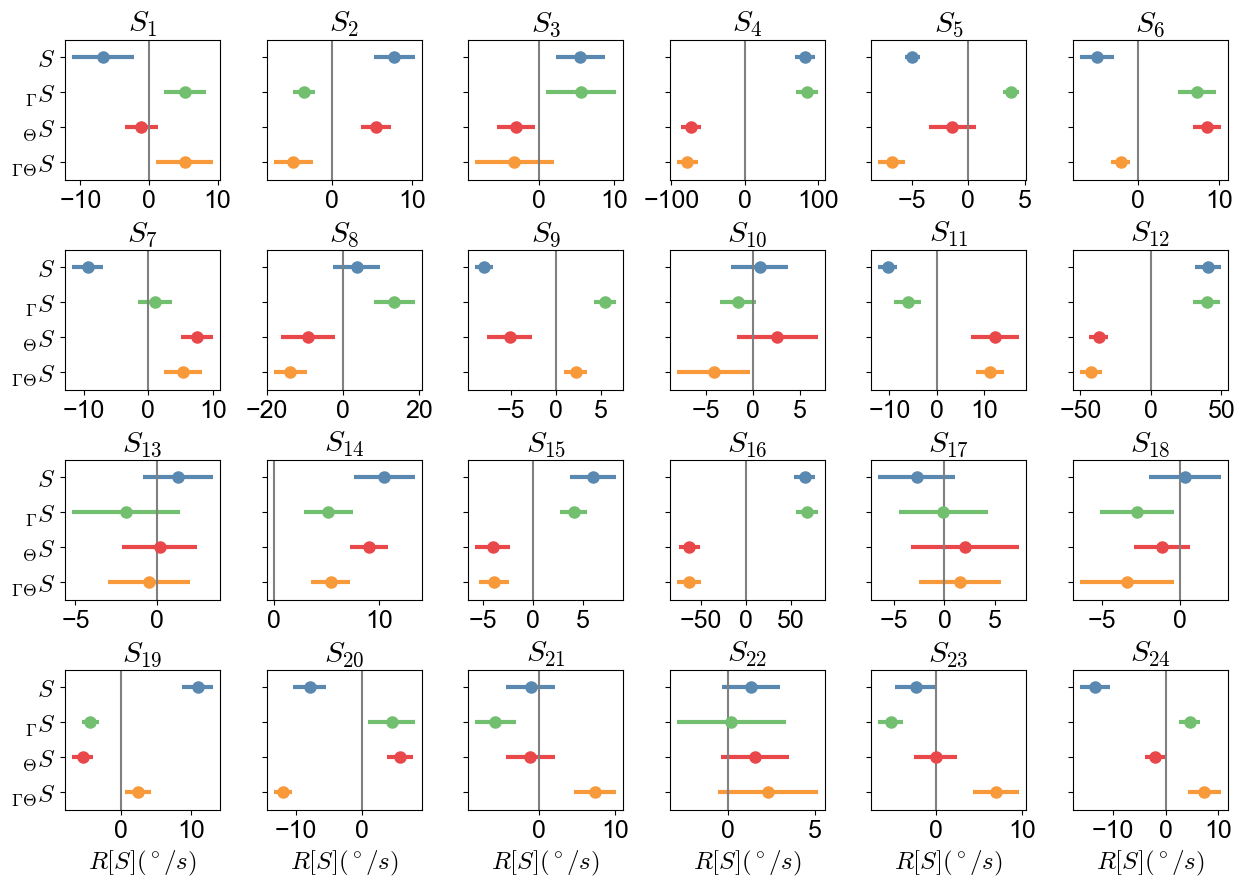

In [80]:
fig = plt.figure(figsize = (15, 10))
plt.rcParams.update({'font.size': 18})

num_rows = 4
for i in range(1, 25):
    ax = plt.subplot(num_rows, int(24/num_rows), i)

    plt.title("$S_{" + str(i) + "}$")

    plt.yticks(ticks = [0, 1, 2, 3], labels =["", "", "", ""])
    if i % (24/num_rows) == 1:
        plt.yticks(ticks = [3, 2, 1, 0], labels =["$S$", "$_{\Gamma}S$", "$_{\Theta}S$", "$_{\Gamma\Theta}S$"])

    if i > 24 - (24/num_rows):
        plt.xlabel("$R[S] (^\circ/s)$")


    sub_df = indfly_df.loc[indfly_df["stimulus id"] == i, :]
    n_flies = len(sub_df.index)
    jitter = (np.random.rand(n_flies) - 0.5) * 0.3


    for j, version, color in zip(range(0, 4), ["S", "S_c", "S_t", "S_ct"], ["#5989B0", "#72BF6F", "#E9484B", "#F8993A"]):
        ax.errorbar(mean_df_for_graph.loc[i, version], 3-j, xerr = sem_df_for_graph.loc[i, version], fmt = "o", c = color, markersize = 8, linewidth = 3)
        #plt.scatter(sub_df.loc[:, version], jitter + 2.8 - j, c = "grey")

    

    ax.vlines(0, -0.5, 3.5, colors = "grey")
    ax.set_ylim(-0.5, 3.5)
    
plt.subplots_adjust(wspace = 0.3, hspace=0.5)

plt.savefig("../figures/fig3/fig3_supp.pdf", bbox_inches = 'tight')

In [81]:
indfly_df_alt = pd.DataFrame(columns=['version', 'stimulus id', 'S+S_t', 'S-S_c', 'S+S_ct'])

list_1 = indfly_df_combined.loc[:, ['stimulus id', 'S+S_t', 'S-S_c', 'S+S_ct']].values
list_2 = indfly_df_combined.loc[:, ['stimulus id', 'S_c+S_ct', 'S_t-S_ct', 'S_t+S_c']].values

for row in list_1:
    indfly_df_alt.loc[len(indfly_df_alt.index), indfly_df_alt.columns] = ["original"] + list(row)
for row in list_2:
    indfly_df_alt.loc[len(indfly_df_alt.index)] = ["alternate"] + list(row)

indfly_df_alt

,version,stimulus id,S+S_t,S-S_c,S+S_ct
0,original,10.0,3.529826,-3.634588,-6.711531
1,original,10.0,39.641644,27.395692,0.858589
2,original,10.0,9.718412,1.104433,-7.093481
3,original,10.0,9.00717,6.932017,-11.524892
4,original,10.0,-22.346097,-15.686511,4.470686
...,...,...,...,...,...
435,alternate,9.0,0.460818,-0.295105,0.165713
436,alternate,9.0,14.321513,-16.19035,-1.868837
437,alternate,9.0,11.604119,-15.635309,-4.03119
438,alternate,9.0,10.810745,-4.698508,6.112237


In [82]:
indfly_df_full = pd.DataFrame(columns=['base', 'stimulus id', 'combination', 'value'])

for i in indfly_df_alt.index:
    indfly_df_full.loc[len(indfly_df_full.index)] = ["S" if indfly_df_alt.loc[i, "version"] == "original" else "S_c", indfly_df_alt.loc[i, "stimulus id"], "S+S_t", indfly_df_alt.loc[i, "S+S_t"]]
    indfly_df_full.loc[len(indfly_df_full.index)] = ["S" if indfly_df_alt.loc[i, "version"] == "original" else "S_t", indfly_df_alt.loc[i, "stimulus id"], "S-S_c", indfly_df_alt.loc[i, "S-S_c"]]
    indfly_df_full.loc[len(indfly_df_full.index)] = ["S" if indfly_df_alt.loc[i, "version"] == "original" else "S_c", indfly_df_alt.loc[i, "stimulus id"], "S+S_ct", indfly_df_alt.loc[i, "S+S_ct"]]

indfly_df_full


,base,stimulus id,combination,value
0,S,10.0,S+S_t,3.529826
1,S,10.0,S-S_c,-3.634588
2,S,10.0,S+S_ct,-6.711531
3,S,10.0,S+S_t,39.641644
4,S,10.0,S-S_c,27.395692
...,...,...,...,...
1315,S_t,9.0,S-S_c,-4.698508
1316,S_c,9.0,S+S_ct,6.112237
1317,S_c,9.0,S+S_t,2.559905
1318,S_t,9.0,S-S_c,8.464611


In [83]:
for i in indfly_df_full.index:
    stim_id = indfly_df_full.loc[i, "stimulus id"]
    #flag = False
    #create new column "secondary"

    if indfly_df_full.loc[i, "combination"] == "S+S_t":
        if stimulus_df.loc[stim_id, "C"]: #indclude other
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_c"
        elif stimulus_df.loc[stim_id, "CT"]: #include other
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_ct"
        elif stimulus_df.loc[stim_id, "XC"]: #include other, flip
            indfly_df_full.loc[i, "secondary"] = "S_xc"
            if indfly_df_full.loc[i, "base"] != "S":
                indfly_df_full.loc[i, "value"] = indfly_df_full.loc[i, "value"] * -1
            
            indfly_df_full.loc[i, "base"] = "S"

        elif stimulus_df.loc[stim_id, "XCT"]: #include other, flip
            indfly_df_full.loc[i, "secondary"] = "S_xct"
            if indfly_df_full.loc[i, "base"] != "S":
                indfly_df_full.loc[i, "value"] = indfly_df_full.loc[i, "value"] * -1
            
            indfly_df_full.loc[i, "base"] = "S"



    elif indfly_df_full.loc[i, "combination"] == "S-S_c":
        if stimulus_df.loc[stim_id, "T"]: #indclude other
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_t"
        elif stimulus_df.loc[stim_id, "CT"]: #flip
            if indfly_df_full.loc[i, "base"] != "S":
                indfly_df_full.loc[i, "value"] = indfly_df_full.loc[i, "value"] * -1
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_ct"
        elif stimulus_df.loc[stim_id, "XT"]: #flip
            if indfly_df_full.loc[i, "base"] != "S":
                indfly_df_full.loc[i, "value"] = indfly_df_full.loc[i, "value"] * -1
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_xt"
        elif stimulus_df.loc[stim_id, "XCT"]: #include other
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_xct"

    elif indfly_df_full.loc[i, "combination"] == "S+S_ct":
        if stimulus_df.loc[stim_id, "C"]: #indclude other
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_c"
        elif stimulus_df.loc[stim_id, "T"]: #include other
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_t"
        elif stimulus_df.loc[stim_id, "XC"]: #include other, flip
            indfly_df_full.loc[i, "secondary"] = "S_xc"
            if indfly_df_full.loc[i, "base"] != "S":
                indfly_df_full.loc[i, "value"] = indfly_df_full.loc[i, "value"] * -1
            
            indfly_df_full.loc[i, "base"] = "S"
        elif stimulus_df.loc[stim_id, "XT"]: #include other, flip
            if indfly_df_full.loc[i, "base"] != "S":
                indfly_df_full.loc[i, "value"] = indfly_df_full.loc[i, "value"] * -1
            indfly_df_full.loc[i, "base"] = "S"
            indfly_df_full.loc[i, "secondary"] = "S_xt"

    



indfly_df_full
        
    


,base,stimulus id,combination,value,secondary
0,S,10.0,S+S_t,3.529826,S_xc
1,S,10.0,S-S_c,-3.634588,nan
2,S,10.0,S+S_ct,-6.711531,S_xc
3,S,10.0,S+S_t,39.641644,S_xc
4,S,10.0,S-S_c,27.395692,nan
...,...,...,...,...,...
1315,S_t,9.0,S-S_c,-4.698508,nan
1316,S,9.0,S+S_ct,-6.112237,S_xc
1317,S,9.0,S+S_t,-2.559905,S_xc
1318,S_t,9.0,S-S_c,8.464611,nan


In [84]:
indfly_df_grouped =indfly_df_full.groupby(['stimulus id',"base", "combination", 'secondary'])
indfly_df_multiindex = indfly_df_full.set_index(['stimulus id', 'base', 'combination', 'secondary'], append = True)
indfly_df_multiindex

,,,,,value
,stimulus id,base,combination,secondary,
0,10.0,S,S+S_t,S_xc,3.529826
1,10.0,S,S-S_c,nan,-3.634588
2,10.0,S,S+S_ct,S_xc,-6.711531
3,10.0,S,S+S_t,S_xc,39.641644
4,10.0,S,S-S_c,nan,27.395692
...,...,...,...,...,...
1315,9.0,S_t,S-S_c,nan,-4.698508
1316,9.0,S,S+S_ct,S_xc,-6.112237
1317,9.0,S,S+S_t,S_xc,-2.559905


In [85]:
def pval_uncorrected(x):
    return ttest_1samp(x, popmean = 0)[1]

agg_df = indfly_df_grouped.agg(["mean", "sem", pval_uncorrected])
agg_df.columns = agg_df.columns.droplevel()

agg_df.head(15)

mean       sem  pval_uncorrected
stimulus id base combination secondary                                       
1.0         S    S+S_ct      S_t         1.284156  1.689743          0.456599
                 S+S_t       nan        -7.844956  6.518188          0.259465
                 S-S_c       S_t        -9.129112  4.770801          0.070867
            S_c  S+S_t       nan        10.413267  6.960574          0.168861
2.0         S    S+S_ct      S_t         2.462117  2.119849          0.259839
                 S+S_t       nan        13.335276  3.267041          0.002751
                 S-S_c       S_t        10.873160  2.185447          0.000084
            S_c  S+S_t       nan        -8.411043  3.790419          0.053649
3.0         S    S+S_ct      S_c         2.475759  1.760662          0.177694
                 S+S_t       S_c         2.475759  1.499542          0.117087
                 S-S_c       nan        -0.091356  2.482551          0.971547
            S_t  S-S_c       nan         0.208691  3.041858          0.946987
4.0         S    S+S_ct      S_c         6.778122  2.913084          0.032593
                 S+S_t       S_c         6.778122  2.711262          0.022948
                 S-S_c       nan        -3.281168  3.937984          0.428899

In [86]:
agg_df["mean_abs"] = agg_df["mean"].apply(np.abs)
agg_df

mean       sem  pval_uncorrected  \
stimulus id base combination secondary                                          
1.0         S    S+S_ct      S_t         1.284156  1.689743          0.456599   
                 S+S_t       nan        -7.844956  6.518188          0.259465   
                 S-S_c       S_t        -9.129112  4.770801          0.070867   
            S_c  S+S_t       nan        10.413267  6.960574          0.168861   
2.0         S    S+S_ct      S_t         2.462117  2.119849          0.259839   
...                                           ...       ...               ...   
24.0        S    S+S_t       nan       -15.575188  2.986115          0.000392   
                 S-S_c       nan       -18.058205  3.171883          0.000200   
            S_c  S+S_ct      nan         2.483017  2.256295          0.296906   
                 S+S_t       nan        11.927009  3.125738          0.003397   
            S_t  S-S_c       nan        -9.443992  4.045991          0.041753   

                                         mean_abs  
stimulus id base combination secondary             
1.0         S    S+S_ct      S_t         1.284156  
                 S+S_t       nan         7.844956  
                 S-S_c       S_t         9.129112  
            S_c  S+S_t       nan        10.413267  
2.0         S    S+S_ct      S_t         2.462117  
...                                           ...  
24.0        S    S+S_t       nan        15.575188  
                 S-S_c       nan        18.058205  
            S_c  S+S_ct      nan         2.483017  
                 S+S_t       nan        11.927009  
            S_t  S-S_c       nan         9.443992  

[96 rows x 4 columns]

In [87]:
def ttest_corrected(group):
    uncorrected_p_values = list()
    for col in group.columns[1:]:
        _, p_value = ttest_1samp(group[col], popmean = 0)
        uncorrected_p_values.append(p_value)

    corrected_p_values = multipletests(uncorrected_p_values, method = 'holm')[1]

    p_values_dict = dict(zip(group.columns[1:], corrected_p_values))


    return pd.Series(p_values_dict)

agg_df.loc[(1), :]

for i in agg_df.index.get_level_values(0).unique():
    sub_df = agg_df.loc[(i), :]
    p_vals = list(sub_df["pval_uncorrected"])
    corrected_p_vals = multipletests(p_vals, method = 'holm')[1]

    agg_df.loc[(i), "pval_corrected"] = corrected_p_vals

agg_df.to_csv(Path(folder, 'all_stims.csv'), index = True)
agg_df.head(15)


mean       sem  pval_uncorrected  \
stimulus id base combination secondary                                          
1.0         S    S+S_ct      S_t         1.284156  1.689743          0.456599   
                 S+S_t       nan        -7.844956  6.518188          0.259465   
                 S-S_c       S_t        -9.129112  4.770801          0.070867   
            S_c  S+S_t       nan        10.413267  6.960574          0.168861   
2.0         S    S+S_ct      S_t         2.462117  2.119849          0.259839   
                 S+S_t       nan        13.335276  3.267041          0.002751   
                 S-S_c       S_t        10.873160  2.185447          0.000084   
            S_c  S+S_t       nan        -8.411043  3.790419          0.053649   
3.0         S    S+S_ct      S_c         2.475759  1.760662          0.177694   
                 S+S_t       S_c         2.475759  1.499542          0.117087   
                 S-S_c       nan        -0.091356  2.482551          0.971547   
            S_t  S-S_c       nan         0.208691  3.041858          0.946987   
4.0         S    S+S_ct      S_c         6.778122  2.913084          0.032593   
                 S+S_t       S_c         6.778122  2.711262          0.022948   
                 S-S_c       nan        -3.281168  3.937984          0.428899   

                                         mean_abs  pval_corrected  
stimulus id base combination secondary                             
1.0         S    S+S_ct      S_t         1.284156        0.518929  
                 S+S_t       nan         7.844956        0.518929  
                 S-S_c       S_t         9.129112        0.283470  
            S_c  S+S_t       nan        10.413267        0.506584  
2.0         S    S+S_ct      S_t         2.462117        0.259839  
                 S+S_t       nan        13.335276        0.008252  
                 S-S_c       S_t        10.873160        0.000336  
            S_c  S+S_t       nan         8.411043        0.107298  
3.0         S    S+S_ct      S_c         2.475759        0.533083  
                 S+S_t       S_c         2.475759        0.468350  
                 S-S_c       nan         0.091356        1.000000  
            S_t  S-S_c       nan         0.208691        1.000000  
4.0         S    S+S_ct      S_c         6.778122        0.097780  
                 S+S_t       S_c         6.778122        0.091794  
                 S-S_c       nan         3.281168        0.428899

In [88]:
symm_columns = ['T', 'C', 'CT', 'XT', 'XC', 'XCT']

full_agg_df = agg_df.copy()
    
full_agg_df[symm_columns] = [stimulus_df.loc[i, symm_columns].astype(int) for i in agg_df.index.get_level_values(0)]

net_edge_columns = ['net light', 'net dark']


for multiindex in full_agg_df.index:
    columns = stimulus_df.loc[multiindex[0], net_edge_columns].values
    if multiindex[1] == 'S_t':
        columns = np.flip(columns) * -1
    elif multiindex[1] == 'S_c':
        columns = np.flip(columns)
       
    full_agg_df.loc[multiindex, net_edge_columns] = columns

full_agg_df

mean       sem  pval_uncorrected  \
stimulus id base combination secondary                                          
1.0         S    S+S_ct      S_t         1.284156  1.689743          0.456599   
                 S+S_t       nan        -7.844956  6.518188          0.259465   
                 S-S_c       S_t        -9.129112  4.770801          0.070867   
            S_c  S+S_t       nan        10.413267  6.960574          0.168861   
2.0         S    S+S_ct      S_t         2.462117  2.119849          0.259839   
...                                           ...       ...               ...   
24.0        S    S+S_t       nan       -15.575188  2.986115          0.000392   
                 S-S_c       nan       -18.058205  3.171883          0.000200   
            S_c  S+S_ct      nan         2.483017  2.256295          0.296906   
                 S+S_t       nan        11.927009  3.125738          0.003397   
            S_t  S-S_c       nan        -9.443992  4.045991          0.041753   

                                         mean_abs  pval_corrected  T  C  CT  \
stimulus id base combination secondary                                        
1.0         S    S+S_ct      S_t         1.284156        0.518929  1  0   0   
                 S+S_t       nan         7.844956        0.518929  1  0   0   
                 S-S_c       S_t         9.129112        0.283470  1  0   0   
            S_c  S+S_t       nan        10.413267        0.506584  1  0   0   
2.0         S    S+S_ct      S_t         2.462117        0.259839  1  0   0   
...                                           ...             ... .. ..  ..   
24.0        S    S+S_t       nan        15.575188        0.001961  0  0   0   
                 S-S_c       nan        18.058205        0.001201  0  0   0   
            S_c  S+S_ct      nan         2.483017        0.296906  0  0   0   
                 S+S_t       nan        11.927009        0.013589  0  0   0   
            S_t  S-S_c       nan         9.443992        0.100045  0  0   0   

                                        XT  XC  XCT  net light  net dark  
stimulus id base combination secondary                                    
1.0         S    S+S_ct      S_t         0   0    0        0.0       0.0  
                 S+S_t       nan         0   0    0        0.0       0.0  
                 S-S_c       S_t         0   0    0        0.0       0.0  
            S_c  S+S_t       nan         0   0    0        0.0       0.0  
2.0         S    S+S_ct      S_t         0   0    0       -2.0       2.0  
...                                     ..  ..  ...        ...       ...  
24.0        S    S+S_t       nan         0   0    0        2.0      -2.0  
                 S-S_c       nan         0   0    0        2.0      -2.0  
            S_c  S+S_ct      nan         0   0    0       -2.0       2.0  
                 S+S_t       nan         0   0    0       -2.0       2.0  
            S_t  S-S_c       nan         0   0    0        2.0      -2.0  

[96 rows x 13 columns]

In [89]:
indfly_df_multiindex["pos_mean_value"] = indfly_df_multiindex["value"]
columns = ['T', 'C', 'CT', 'XT', 'XC', 'XCT', "net light", "net dark"]

for multiindex in indfly_df_multiindex.index:
    indfly_df_multiindex.loc[multiindex, columns] = full_agg_df.loc[multiindex[1:], columns]
    if full_agg_df.loc[multiindex[1:], 'mean'] < 0:
        indfly_df_multiindex.loc[multiindex, "pos_mean_value"] = indfly_df_multiindex.loc[multiindex, "value"] * -1
indfly_df_multiindex

,,,,,value,pos_mean_value,T,C,CT,XT,XC,XCT,net light,net dark
,stimulus id,base,combination,secondary,,,,,,,,,,
0,10.0,S,S+S_t,S_xc,3.529826,3.529826,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1,10.0,S,S-S_c,nan,-3.634588,-3.634588,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
2,10.0,S,S+S_ct,S_xc,-6.711531,6.711531,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
3,10.0,S,S+S_t,S_xc,39.641644,39.641644,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
4,10.0,S,S-S_c,nan,27.395692,27.395692,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,9.0,S_t,S-S_c,nan,-4.698508,4.698508,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1316,9.0,S,S+S_ct,S_xc,-6.112237,6.112237,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1317,9.0,S,S+S_t,S_xc,-2.559905,2.559905,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0


In [90]:
t_flip_indfly_df = indfly_df_multiindex.loc[indfly_df_multiindex.index.get_level_values("combination") == "S+S_t", :]
c_flip_indfly_df = indfly_df_multiindex.loc[indfly_df_multiindex.index.get_level_values("combination") == "S-S_c", :]
ct_flip_indfly_df = indfly_df_multiindex.loc[indfly_df_multiindex.index.get_level_values("combination") == "S+S_ct", :]

display(t_flip_indfly_df)
display(c_flip_indfly_df)
display(ct_flip_indfly_df.loc[ct_flip_indfly_df.index.get_level_values("stimulus id") == 2, :])

,,,,,value,pos_mean_value,T,C,CT,XT,XC,XCT,net light,net dark
,stimulus id,base,combination,secondary,,,,,,,,,,
0,10.0,S,S+S_t,S_xc,3.529826,3.529826,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
3,10.0,S,S+S_t,S_xc,39.641644,39.641644,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
6,10.0,S,S+S_t,S_xc,9.718412,9.718412,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
9,10.0,S,S+S_t,S_xc,9.007170,9.007170,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
12,10.0,S,S+S_t,S_xc,-22.346097,-22.346097,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9.0,S,S+S_t,S_xc,-0.460818,0.460818,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1308,9.0,S,S+S_t,S_xc,-14.321513,14.321513,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1311,9.0,S,S+S_t,S_xc,-11.604119,11.604119,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0


,,,,,value,pos_mean_value,T,C,CT,XT,XC,XCT,net light,net dark
,stimulus id,base,combination,secondary,,,,,,,,,,
1,10.0,S,S-S_c,nan,-3.634588,-3.634588,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
4,10.0,S,S-S_c,nan,27.395692,27.395692,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
7,10.0,S,S-S_c,nan,1.104433,1.104433,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
10,10.0,S,S-S_c,nan,6.932017,6.932017,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
13,10.0,S,S-S_c,nan,-15.686511,-15.686511,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,9.0,S_t,S-S_c,nan,-0.295105,0.295105,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1309,9.0,S_t,S-S_c,nan,-16.190350,16.190350,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0
1312,9.0,S_t,S-S_c,nan,-15.635309,15.635309,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-2.0


,,,,,value,pos_mean_value,T,C,CT,XT,XC,XCT,net light,net dark
,stimulus id,base,combination,secondary,,,,,,,,,,
446,2.0,S,S+S_ct,S_t,1.440011,1.440011,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
449,2.0,S,S+S_ct,S_t,30.339785,30.339785,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
452,2.0,S,S+S_ct,S_t,-2.042086,-2.042086,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
455,2.0,S,S+S_ct,S_t,14.370622,14.370622,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
458,2.0,S,S+S_ct,S_t,-5.572728,-5.572728,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
461,2.0,S,S+S_ct,S_t,3.452625,3.452625,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
464,2.0,S,S+S_ct,S_t,1.462516,1.462516,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
467,2.0,S,S+S_ct,S_t,-8.449093,-8.449093,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0
470,2.0,S,S+S_ct,S_t,-0.967298,-0.967298,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0


# OLS with symmetries

In [91]:
# #Preparation for OLS with SYMMETRIES
# list_1 = indfly_df_combined_positive.loc[:, ['stimulus id', 'S+S_t', 'S-S_c', 'S+S_ct']].values
# list_2 = indfly_df_combined_positive.loc[:, ['stimulus id', 'S_c+S_ct', 'S_t-S_ct', 'S_t+S_c']].values

# indfly_df_condensed_positive = pd.DataFrame(columns = ['stimulus id', 't flip sum', 'c flip diff', 'ct flip sum'], data = np.vstack([list_1, list_2]))
columns = ['T', 'C', 'CT', 'XT', 'XC', 'XCT']
    
# indfly_df_condensed_positive[columns] = [stimulus_df.loc[indfly_df_condensed_positive.loc[i, 'stimulus id'], columns].astype(int) for i in indfly_df_condensed_positive.index]

# display(indfly_df_condensed_positive)

t_flip_ols = OLS(t_flip_indfly_df['pos_mean_value'], exog = add_constant(t_flip_indfly_df[columns]), hasconst = True)
c_flip_ols = OLS(c_flip_indfly_df['pos_mean_value'], exog = add_constant(c_flip_indfly_df[columns]), hasconst = True)
ct_flip_ols = OLS(ct_flip_indfly_df['pos_mean_value'], exog = add_constant(ct_flip_indfly_df[columns]), hasconst = True)


t_flip_ols_results_symmetry =t_flip_ols.fit()
c_flip_ols_results_symmetry = c_flip_ols.fit()
ct_flip_ols_results_symmetry = ct_flip_ols.fit()

#https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults
print(t_flip_ols_results_symmetry.summary())
print(c_flip_ols_results_symmetry.summary())
print(ct_flip_ols_results_symmetry.summary())




                            OLS Regression Results                            
Dep. Variable:         pos_mean_value   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.252
Date:                Mon, 16 Sep 2024   Prob (F-statistic):             0.0375
Time:                        16:11:30   Log-Likelihood:                -1705.1
No. Observations:                 440   AIC:                             3424.
Df Residuals:                     433   BIC:                             3453.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6330      0.904      6.232      0.0

# OLS with net edges

In [92]:
columns = ['net light', 'net dark']
    
# indfly_df_condensed_positive[columns] = [stimulus_df.loc[indfly_df_condensed_positive.loc[i, 'stimulus id'], columns].astype(int) for i in indfly_df_condensed_positive.index]

# display(indfly_df_condensed_positive)

t_flip_ols_edge_imbalance = OLS(t_flip_indfly_df['value'], exog = t_flip_indfly_df[columns])
c_flip_ols_edge_imbalance = OLS(c_flip_indfly_df['value'], exog = c_flip_indfly_df[columns])
ct_flip_ols_edge_imbalance = OLS(ct_flip_indfly_df['value'], exog = ct_flip_indfly_df[columns])


t_flip_ols_results_edges =t_flip_ols_edge_imbalance.fit()
c_flip_ols_results_edges = c_flip_ols_edge_imbalance.fit()
ct_flip_ols_results_edges = ct_flip_ols_edge_imbalance.fit()

#https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults
print(t_flip_ols_results_edges.summary())
#print(t_flip_results.t_test(np.eye(7)))
print(c_flip_ols_results_edges.summary())
print(ct_flip_ols_results_edges.summary())


                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   0.046
Model:                            OLS   Adj. R-squared (uncentered):              0.041
Method:                 Least Squares   F-statistic:                              10.51
Date:                Mon, 16 Sep 2024   Prob (F-statistic):                    3.47e-05
Time:                        16:11:30   Log-Likelihood:                         -1735.4
No. Observations:                 440   AIC:                                      3475.
Df Residuals:                     438   BIC:                                      3483.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Make figure 4

In [93]:
t_flips = ['S+S_t', 'S_c+S_ct']
c_flips = ['S-S_c', 'S_t-S_ct']
ct_flips = ['S+S_ct', 'S_t+S_c']

t_flips_df = full_agg_df.loc[full_agg_df.index.get_level_values("combination") == "S+S_t", :]
c_flips_df = full_agg_df.loc[full_agg_df.index.get_level_values("combination") == "S-S_c", :]
ct_flips_df = full_agg_df.loc[full_agg_df.index.get_level_values("combination") == "S+S_ct", :]

#t_flips_df['const'] = 1
t_flips_df = t_flips_df.assign(const = 1).sort_values(by = 'mean_abs', ascending = False).reset_index()
c_flips_df = c_flips_df.assign(const = 1).sort_values(by = 'mean_abs', ascending = False).reset_index()
ct_flips_df = ct_flips_df.assign(const = 1).sort_values(by = 'mean_abs', ascending = False).reset_index()



t_flips_df['predicted symmetries ols mean'] = [t_flip_ols_results_symmetry.predict(t_flips_df.loc[i, ['const', 'T', 'C', 'CT', 'XT', 'XC', 'XCT']].values)[0] for i in t_flips_df.index]
c_flips_df['predicted symmetries ols mean'] = [c_flip_ols_results_symmetry.predict(c_flips_df.loc[i, ['const', 'T', 'C', 'CT', 'XT', 'XC', 'XCT']].values)[0] for i in c_flips_df.index]
ct_flips_df['predicted symmetries ols mean'] = [ct_flip_ols_results_symmetry.predict(ct_flips_df.loc[i, ['const', 'T', 'C', 'CT', 'XT', 'XC', 'XCT']].values)[0] for i in ct_flips_df.index]

t_flips_df['predicted edges ols mean'] = [t_flip_ols_results_edges.predict(t_flips_df.loc[i, ['net light', 'net dark']].values)[0] for i in t_flips_df.index]
c_flips_df['predicted edges ols mean'] = [c_flip_ols_results_edges.predict(c_flips_df.loc[i, ['net light', 'net dark']].values)[0] for i in c_flips_df.index]
ct_flips_df['predicted edges ols mean'] = [ct_flip_ols_results_edges.predict(ct_flips_df.loc[i, ['net light', 'net dark']].values)[0] for i in ct_flips_df.index]



display(t_flips_df.head())
display(c_flips_df.head())
display(ct_flips_df.head())



,stimulus id,base,combination,secondary,mean,sem,pval_uncorrected,mean_abs,pval_corrected,T,C,CT,XT,XC,XCT,net light,net dark,const,predicted symmetries ols mean,predicted edges ols mean
0,24.0,S,S+S_t,nan,-15.575188,2.986115,0.000392,15.575188,0.001961,0,0,0,0,0,0,2.0,-2.0,1,5.633026,-4.076006
1,14.0,S,S+S_t,S_c,15.087171,2.457437,0.000019,15.087171,0.000057,1,1,1,0,0,0,0.0,0.0,1,7.634706,0.000000
2,2.0,S,S+S_t,nan,13.335276,3.267041,0.002751,13.335276,0.008252,1,0,0,0,0,0,-2.0,2.0,1,8.301157,4.076006
3,24.0,S_c,S+S_t,nan,11.927009,3.125738,0.003397,11.927009,0.013589,0,0,0,0,0,0,-2.0,2.0,1,5.633026,4.076006
4,1.0,S_c,S+S_t,nan,10.413267,6.960574,0.168861,10.413267,0.506584,1,0,0,0,0,0,0.0,0.0,1,8.301157,0.000000


,stimulus id,base,combination,secondary,mean,sem,pval_uncorrected,mean_abs,pval_corrected,T,C,CT,XT,XC,XCT,net light,net dark,const,predicted symmetries ols mean,predicted edges ols mean
0,24.0,S,S-S_c,nan,-18.058205,3.171883,0.000200,18.058205,0.001201,0,0,0,0,0,0,2.0,-2.0,1,6.774747,-4.076006
1,20.0,S,S-S_c,S_ct,-15.084490,3.154968,0.000243,15.084490,0.000545,0,0,1,1,1,0,0.0,0.0,1,11.927114,0.000000
2,9.0,S,S-S_c,nan,-13.443733,1.743851,0.000115,13.443733,0.000346,0,0,0,0,1,0,2.0,-2.0,1,7.273018,-4.076006
3,19.0,S,S-S_c,S_ct,11.705978,2.129616,0.000061,11.705978,0.000123,0,0,1,1,1,0,0.0,0.0,1,11.927114,0.000000
4,6.0,S,S-S_c,S_ct,-11.414236,2.033859,0.000050,11.414236,0.000198,0,0,1,0,0,0,0.0,0.0,1,9.050246,0.000000


,stimulus id,base,combination,secondary,mean,sem,pval_uncorrected,mean_abs,pval_corrected,T,C,CT,XT,XC,XCT,net light,net dark,const,predicted symmetries ols mean,predicted edges ols mean
0,6.0,S_c,S+S_ct,nan,15.736177,2.914583,0.001009,15.736177,0.003028,0,0,1,0,0,0,0.0,0.0,1,10.248922,0.0
1,14.0,S,S+S_ct,S_c,15.087171,2.514767,0.000024,15.087171,0.000057,1,1,1,0,0,0,0.0,0.0,1,7.679788,0.0
2,20.0,S,S+S_ct,S_xc,-15.084490,3.059997,0.000182,15.084490,0.000545,0,0,1,1,1,0,0.0,0.0,1,12.457721,0.0
3,19.0,S,S+S_ct,S_xc,11.705978,2.020594,0.000035,11.705978,0.000106,0,0,1,1,1,0,0.0,0.0,1,12.457721,0.0
4,5.0,S,S+S_ct,nan,-11.675880,1.481204,0.000100,11.675880,0.000300,0,0,1,0,0,0,0.0,0.0,1,10.248922,0.0


In [94]:
t_flips = ['S+S_t', 'S_c+S_ct']
c_flips = ['S-S_c', 'S_t-S_ct']
ct_flips = ['S+S_ct', 'S_t+S_c']

t_flips_df = full_agg_df.loc[full_agg_df.index.get_level_values("combination") == "S+S_t", :]
c_flips_df = full_agg_df.loc[full_agg_df.index.get_level_values("combination") == "S-S_c", :]
ct_flips_df = full_agg_df.loc[full_agg_df.index.get_level_values("combination") == "S+S_ct", :]

#t_flips_df['const'] = 1
t_flips_df = t_flips_df.assign(const = 1).sort_values(by = 'mean_abs', ascending = False).reset_index()
c_flips_df = c_flips_df.assign(const = 1).sort_values(by = 'mean_abs', ascending = False).reset_index()
ct_flips_df = ct_flips_df.assign(const = 1).sort_values(by = 'mean_abs', ascending = False).reset_index()



t_flips_df['predicted symmetries ols mean'] = [t_flip_ols_results_symmetry.predict(t_flips_df.loc[i, ['const', 'T', 'C', 'CT', 'XT', 'XC', 'XCT']].values)[0] for i in t_flips_df.index]
c_flips_df['predicted symmetries ols mean'] = [c_flip_ols_results_symmetry.predict(c_flips_df.loc[i, ['const', 'T', 'C', 'CT', 'XT', 'XC', 'XCT']].values)[0] for i in c_flips_df.index]
ct_flips_df['predicted symmetries ols mean'] = [ct_flip_ols_results_symmetry.predict(ct_flips_df.loc[i, ['const', 'T', 'C', 'CT', 'XT', 'XC', 'XCT']].values)[0] for i in ct_flips_df.index]

t_flips_df['predicted edges ols mean'] = [t_flip_ols_results_edges.predict(t_flips_df.loc[i, ['net light', 'net dark']].values)[0] for i in t_flips_df.index]
c_flips_df['predicted edges ols mean'] = [c_flip_ols_results_edges.predict(c_flips_df.loc[i, ['net light', 'net dark']].values)[0] for i in c_flips_df.index]
ct_flips_df['predicted edges ols mean'] = [ct_flip_ols_results_edges.predict(ct_flips_df.loc[i, ['net light', 'net dark']].values)[0] for i in ct_flips_df.index]



display(t_flips_df.head())
display(c_flips_df.head())
display(ct_flips_df.head())



,stimulus id,base,combination,secondary,mean,sem,pval_uncorrected,mean_abs,pval_corrected,T,C,CT,XT,XC,XCT,net light,net dark,const,predicted symmetries ols mean,predicted edges ols mean
0,24.0,S,S+S_t,nan,-15.575188,2.986115,0.000392,15.575188,0.001961,0,0,0,0,0,0,2.0,-2.0,1,5.633026,-4.076006
1,14.0,S,S+S_t,S_c,15.087171,2.457437,0.000019,15.087171,0.000057,1,1,1,0,0,0,0.0,0.0,1,7.634706,0.000000
2,2.0,S,S+S_t,nan,13.335276,3.267041,0.002751,13.335276,0.008252,1,0,0,0,0,0,-2.0,2.0,1,8.301157,4.076006
3,24.0,S_c,S+S_t,nan,11.927009,3.125738,0.003397,11.927009,0.013589,0,0,0,0,0,0,-2.0,2.0,1,5.633026,4.076006
4,1.0,S_c,S+S_t,nan,10.413267,6.960574,0.168861,10.413267,0.506584,1,0,0,0,0,0,0.0,0.0,1,8.301157,0.000000


,stimulus id,base,combination,secondary,mean,sem,pval_uncorrected,mean_abs,pval_corrected,T,C,CT,XT,XC,XCT,net light,net dark,const,predicted symmetries ols mean,predicted edges ols mean
0,24.0,S,S-S_c,nan,-18.058205,3.171883,0.000200,18.058205,0.001201,0,0,0,0,0,0,2.0,-2.0,1,6.774747,-4.076006
1,20.0,S,S-S_c,S_ct,-15.084490,3.154968,0.000243,15.084490,0.000545,0,0,1,1,1,0,0.0,0.0,1,11.927114,0.000000
2,9.0,S,S-S_c,nan,-13.443733,1.743851,0.000115,13.443733,0.000346,0,0,0,0,1,0,2.0,-2.0,1,7.273018,-4.076006
3,19.0,S,S-S_c,S_ct,11.705978,2.129616,0.000061,11.705978,0.000123,0,0,1,1,1,0,0.0,0.0,1,11.927114,0.000000
4,6.0,S,S-S_c,S_ct,-11.414236,2.033859,0.000050,11.414236,0.000198,0,0,1,0,0,0,0.0,0.0,1,9.050246,0.000000


,stimulus id,base,combination,secondary,mean,sem,pval_uncorrected,mean_abs,pval_corrected,T,C,CT,XT,XC,XCT,net light,net dark,const,predicted symmetries ols mean,predicted edges ols mean
0,6.0,S_c,S+S_ct,nan,15.736177,2.914583,0.001009,15.736177,0.003028,0,0,1,0,0,0,0.0,0.0,1,10.248922,0.0
1,14.0,S,S+S_ct,S_c,15.087171,2.514767,0.000024,15.087171,0.000057,1,1,1,0,0,0,0.0,0.0,1,7.679788,0.0
2,20.0,S,S+S_ct,S_xc,-15.084490,3.059997,0.000182,15.084490,0.000545,0,0,1,1,1,0,0.0,0.0,1,12.457721,0.0
3,19.0,S,S+S_ct,S_xc,11.705978,2.020594,0.000035,11.705978,0.000106,0,0,1,1,1,0,0.0,0.0,1,12.457721,0.0
4,5.0,S,S+S_ct,nan,-11.675880,1.481204,0.000100,11.675880,0.000300,0,0,1,0,0,0,0.0,0.0,1,10.248922,0.0


In [95]:
#https://stackoverflow.com/questions/57168268/matplotlib-table-y-axis-alignment-to-chart
def response_asymmetry_ols(flips_df, ols_results, title, mode = 'edges', save_name = None, color = "r"):
    plt.rcParams.update({'font.size': 26})


    inner_edge_color = 'lightgray'
    if mode == 'symmetry':
        ols_predictions_colname = 'predicted symmetries ols mean'
        mean_type = 'mean_abs'
    elif mode == 'edges':
        ols_predictions_colname = 'predicted edges ols mean'
        mean_type = 'mean'



    # def make_label(stimulus_id, stimulus_combination):
    #     stimulus_label = stimulus_combination.replace('S_ct', '_{\Gamma\Theta}S')
    #     stimulus_label = stimulus_label.replace('S_c', '_{\Gamma}S')
    #     stimulus_label = stimulus_label.replace('S_t', '_{\Theta}S')

    #     stimulus_label = stimulus_label.replace('S', 'S_{' + str(stimulus_id) + '}')
    #     stimulus_label ='$' + stimulus_label + '$'
    #     return stimulus_label

    def format_base(stimulus_id, base, mode = "base"):
        if base == 'S':
            formatted_base = '$S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_c': 
            formatted_base = '$_{\Gamma}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_t': 
            formatted_base = '$_{\Theta}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_ct': 
            formatted_base = '$_{\Gamma\Theta}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_xt': 
            formatted_base = '$_{\chi\Theta}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_xc': 
            formatted_base = '$_{\chi\Gamma}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_xct': 
            formatted_base = '$_{\chi\Gamma\Theta}S_{' + str(int(stimulus_id)) + '}$'
        else:
            return ""

        if mode != "base":
            formatted_base = "(" + formatted_base + ")"

        return formatted_base

    
    table_width = 0.7
    extra_factor = 0.65
    if mode == "edges":
        extra_factor = 0.5
    if mode == 'edges':
        table_width = table_width/1.7
    fig = plt.figure(figsize = (10, 17))
    ax_dict = fig.subplot_mosaic(
        """
        .A
        B.
        """,
        height_ratios = [0.7, 0.08],
        width_ratios = [table_width*extra_factor, 1]
    )


    plt.suptitle(title)
    ax = ax_dict['A']
    #ax.set_title(title)
    #plt.subplot(2, 1, 1)
    ax.errorbar(flips_df[mean_type], flips_df.index, xerr = flips_df['sem'], fmt = "o", c = color, markersize = 10, linewidth = 3)

    #plt.yticks(flips_df.index, ((stimulus_df.loc[flips_df['stimulus id'][i], 'Stimulus type'] + ', ' + flips_df['stimulus combination'][i]) for i in flips_df.index), rotation = 'horizontal')
    ax.set_yticks([], [])

    if mode == 'symmetry':
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)


    for i in flips_df.index:
        #significance stars while we're at it
        if flips_df['pval_corrected'][i] < 0.001:
            ax.text(0, i, ' $*$$*$$*$  ', va = 'center', ha = ('left' if mode == 'symmetry' else 'right'), c = 'k', rotation = 'horizontal' )
        elif flips_df['pval_corrected'][i] < 0.01:
            ax.text(0, i, ' $*$$*$  ', va = 'center', ha = ('left' if mode == 'symmetry' else 'right'), c = 'k', rotation = 'horizontal' )
        elif flips_df['pval_corrected'][i] < 0.05:
            ax.text(0, i, ' $*$  ', va = 'center', ha = ('left' if mode == 'symmetry' else 'right'), c = 'k', rotation = 'horizontal' )
    ax.margins(y=0)

    #get x label
    if flips_df.loc[0, 'combination'] == 'S+S_t':
        x_label = 'R[S]+R[_{\Theta}S]'
    elif flips_df.loc[0, 'combination'] == 'S-S_c':
        x_label = 'R[S]-R[_{\Gamma}S]'
    elif flips_df.loc[0, 'combination'] == 'S+S_ct':
        x_label = 'R[S]+R[_{\Gamma\Theta}S]'

    if mode == 'symmetry':
        ax.set_xlabel('$' + x_label + ' (^{\circ}/s)$\n(positive)')
    elif mode == 'edges':
        ax.set_xlabel('$' + x_label + ' (^{\circ}/s)$')

    if mode == 'symmetry':
        ax.set_xlim(left = 0)
    ax.set_ylim(-0.5, len(flips_df) - 0.5)
    #significance stars
    ax.vlines(0, -0.5, len(flips_df)- 0.5, colors = 'grey')



    #print(prediction_results[0].summary_frame())
    ax.errorbar([flips_df.loc[i, ols_predictions_colname] for i in flips_df.index], flips_df.index, c = 'k', fmt = "o", markersize = 10, linewidth = 3)



    if mode == 'symmetry':
        rows = ['T', 'C', 'CT', 'XT', 'XC', 'XCT']
    elif mode == 'edges':
        rows = ['net light', 'net dark']
    

    base_labels = [format_base(flips_df['stimulus id'][i], flips_df['base'][i]) for i in flips_df.index]
    secondary_labels = [[format_base(flips_df['stimulus id'][i], flips_df['secondary'][i], mode = "secondary")] for i in flips_df.index]

    int_values = flips_df[rows].values.astype(int)

    if mode == 'symmetry':
        table_values = [['' if cell == 0 else '●' for cell in row] for row in int_values]
    elif mode == 'edges':
        def get_string(num):
            if num == 0:
                return ''
            elif num == 2:
                #return '+'
                return '$+2$'
            elif num == -2:
                #return '-'
                return '$-2$'
        table_values = [[get_string(cell) for cell in row] for row in int_values]
    #colors = [['red' if cell == 0 else 'green' for cell in row] for row in int_values]
    for i in range(0, len(table_values)):
        table_values[i] = secondary_labels[i] + table_values[i]

    if mode == 'symmetry':
        col_labels = [
            "",
            '$\Theta$',
            '$\Gamma$',
            '$\Gamma\Theta$',
            '$\chi\Theta$',
            '$\chi\Gamma$',
            '$\chi\Gamma\Theta$'
        ]
    elif mode == 'edges':
        col_labels = ["", 'Light', 'Dark']

    table = ax.table(cellText=table_values,
                        #cellColours=colors,
                        #rowLabels=[(stimulus_df.loc[flips_df['stimulus id'][i], 'Stimulus type'] + ', ' + flips_df['stimulus combination'][i]) for i in flips_df.index[::-1]],
                        #colLabels=[('S_' + str(flips_df['stimulus id'][i]) + ', ' + flips_df['stimulus combination'][i]) for i in flips_df.index[::1]],
                        #rowHeights=[0.1 for x in rows],
                        colWidths = [1 - extra_factor] + [extra_factor/(len(col_labels) - 1)] * 6,
                        colLabels=col_labels,
                        rowLabels = base_labels,
                        cellLoc='center',
                        rowLoc = 'center',
                        loc = 'left',
                        bbox = (-1 * table_width, 0, table_width, 1 + 1/len(flips_df)),
                        edges = 'B'
    )

    for cell_id in table._cells:
        table._cells[cell_id].set(edgecolor = inner_edge_color)
        
        if cell_id[1] == -1:
            table._cells[cell_id].set(edgecolor = 'k')
            table._cells[cell_id].visible_edges = ''
        if cell_id[1] == 0:
            table._cells[cell_id].set(edgecolor = 'k')
            table._cells[cell_id].visible_edges = 'R'
        if cell_id[0] == 0:
            if cell_id[1] <= 0:
                table._cells[cell_id].visible_edges = ''
            else:
                table._cells[cell_id].visible_edges = 'B'
            table._cells[cell_id].set(edgecolor = 'k')
            table._cells[cell_id].set_text_props(rotation = 45)
            #table._cells[cell_id].set_text_props(rotation_mode = 'anchor')
            table._cells[cell_id].set_text_props(va = 'bottom')
            table._cells[cell_id].set_text_props(ha = 'left')
            #table._cells[cell_id].visible_edges = 'R'
        if mode == 'edges' and cell_id[1] >= 1 and cell_id[0] >= 1:
            table._cells[cell_id].set_text_props(fontsize = 26)



    table.auto_set_font_size(False)

    #table.auto_set_column_width(col = list(range(len(modified_stimulus_df.columns))))

    ax.invert_yaxis()
    ax.tick_params(top = True, labeltop = True, bottom = True, labelbottom = True)
    #ax.xaxis.set_label_position('top') # THIS IS THE ONLY CHANGE





    ax = ax_dict['B']
    ax.set_xticks([], [])
    #ax.set_xlim([-8, 8])
    ax.set_xlim([0, len(rows)])
    ax.margins(x = 0)
    ax.set_ylabel(r'$ \beta $')

    ax.hlines(0, 0, len(rows), colors = 'grey')


    ax.errorbar(np.arange(0, len(rows)) + 0.5, ols_results.params[rows], yerr = ols_results.bse[rows].values.reshape(-1), fmt ="o", c = 'k', markersize = 10, linewidth = 3)
    p_values = ols_results.pvalues[rows]

    for i, symmetry in enumerate(p_values.index):

        if p_values[symmetry] < 0.001:
            ax.text( i + 0.5, 0, '$*$$*$$*$', va = 'bottom', ha = 'center', c = 'k', rotation = 'horizontal')
        elif p_values[symmetry] < 0.01:
            ax.text( i + 0.5, 0, '$*$$*$', va = 'bottom', ha = 'center', c = 'k', rotation = 'horizontal')
        elif p_values[symmetry] < 0.05:
            ax.text( i + 0.5, 0, '$*$', va = 'bottom', ha = 'center', c = 'k', rotation = 'horizontal')
        # if flips_df['p corrected'][i] < 0.001:
        #     ax.text(i+0.2, -0.3, '***', ha = 'center', va = 'top', c = 'r', rotation = 'vertical')
        # elif flips_df['p corrected'][i] < 0.01:
        #     ax.text(i+0.2, -0.3, '**', ha = 'center', va = 'top', c = 'r', rotation = 'vertical')
        # elif flips_df['p corrected'][i] < 0.05:
        #     ax.text(i+0.2, -0.3, '*',  ha = 'center', va = 'top', c = 'r', rotation = 'vertical')







    plt.subplots_adjust(wspace=0, hspace=0, top = 0.88)

    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight')

    plt.show()




    plt.figure(figsize = (10, 10))
    plt.title(title)
    plt.scatter(flips_df[ols_predictions_colname], flips_df[mean_type])
    plt.xlabel('Predicted response asymmetry (°/s)')
    plt.ylabel('Actual response asymmetry (°/s)')
    linreg = linregress(flips_df[ols_predictions_colname], flips_df[mean_type])
    plt.plot(flips_df[ols_predictions_colname], linreg.intercept + linreg.slope * flips_df[ols_predictions_colname], 'r')
    plt.text(plt.xlim()[1] * 3/4, plt.ylim()[1] * 1/2, f'$r^2 = {linreg.rvalue**2:.3f}$', fontsize = 20)
    plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


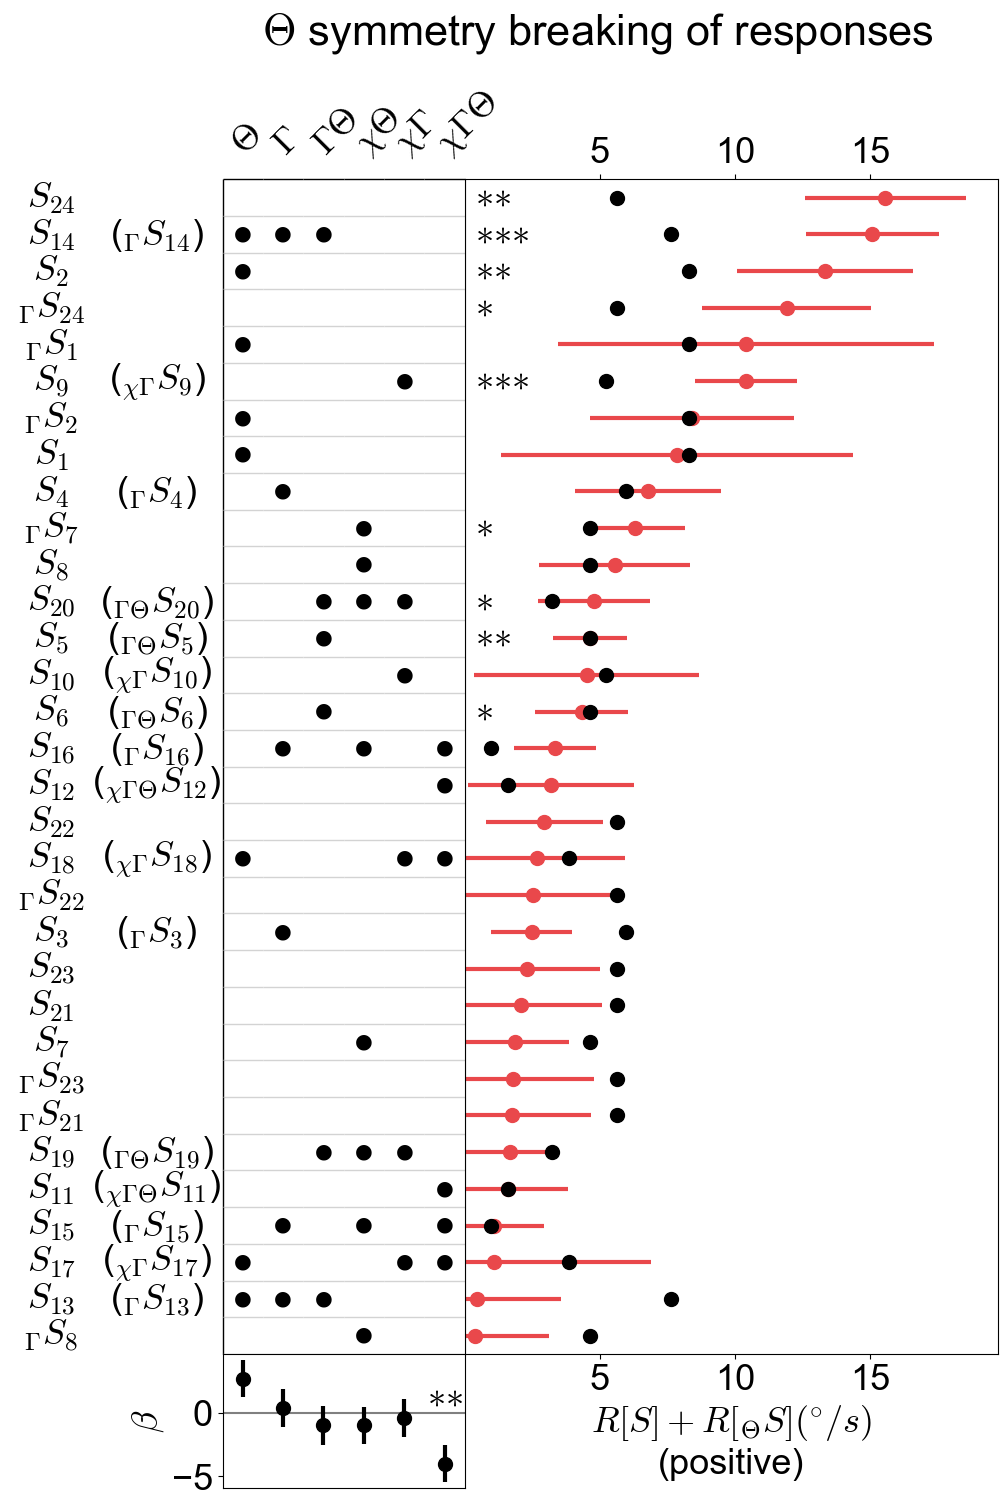

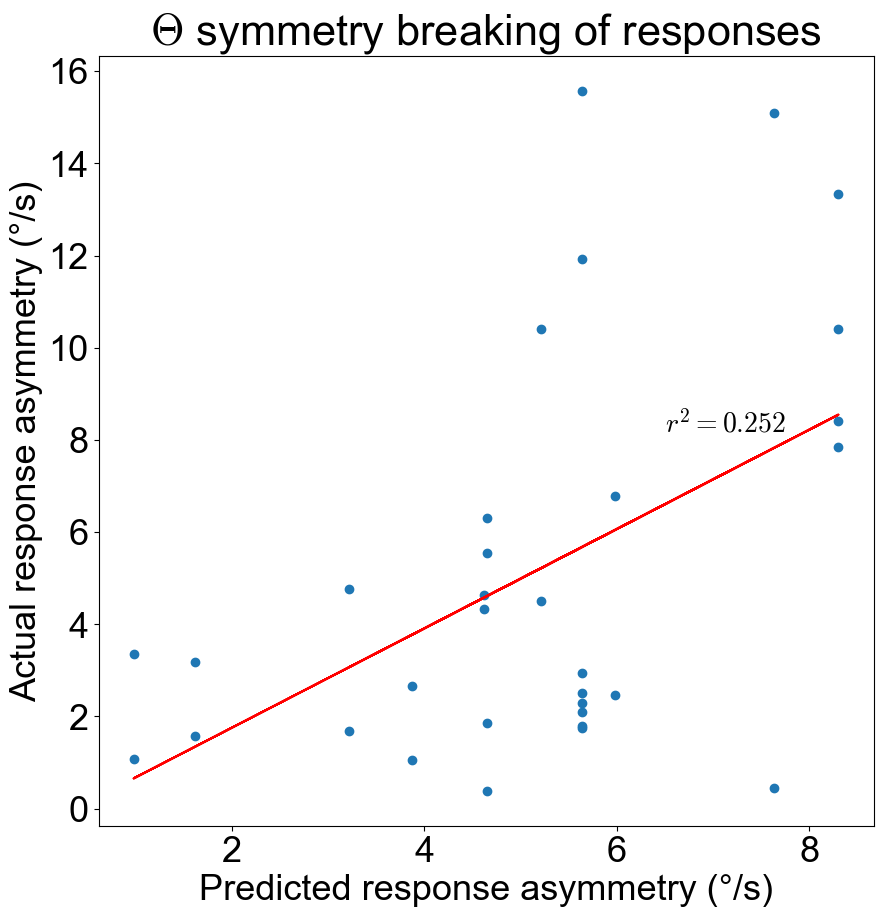

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


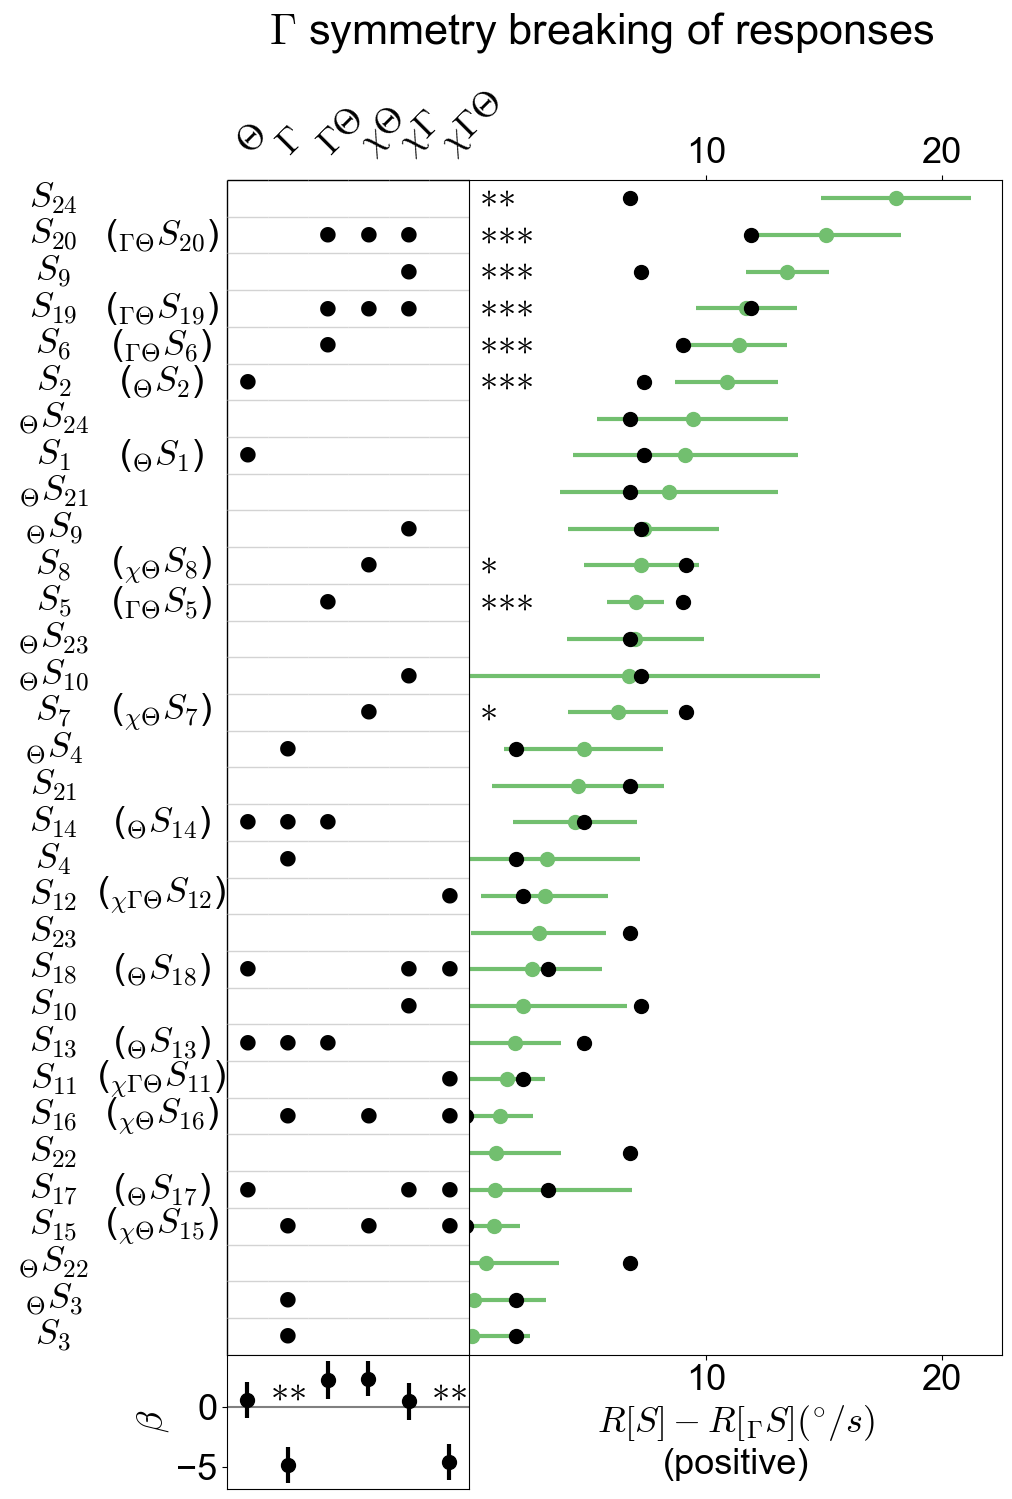

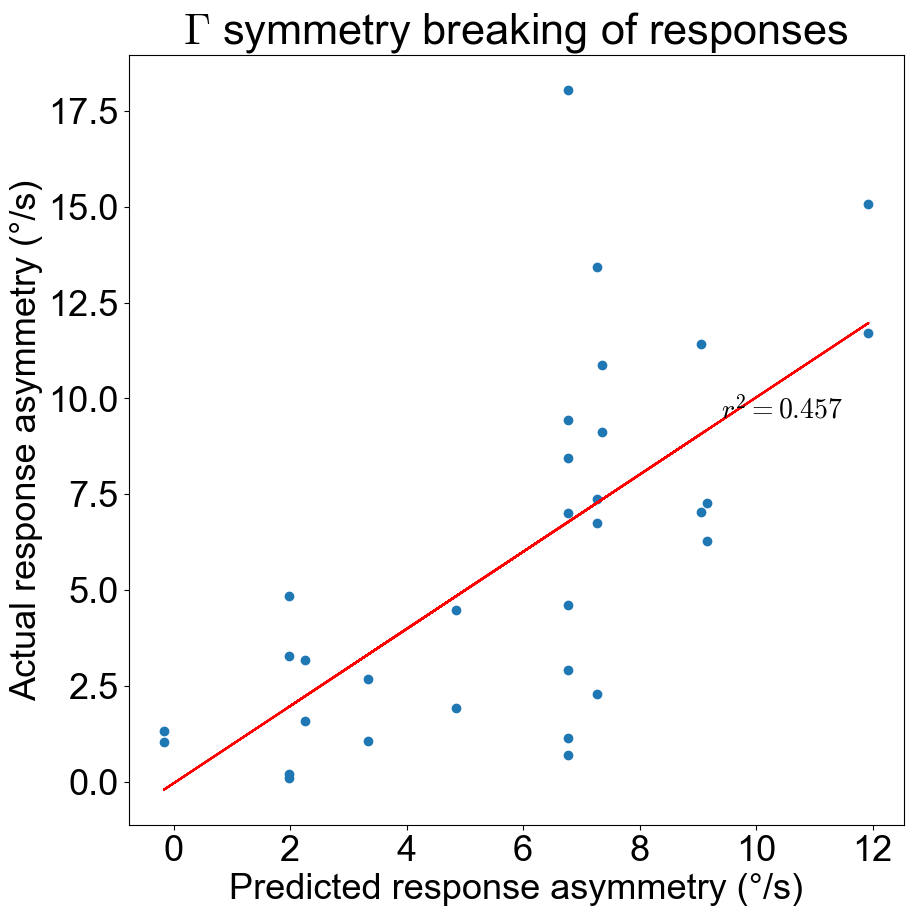

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


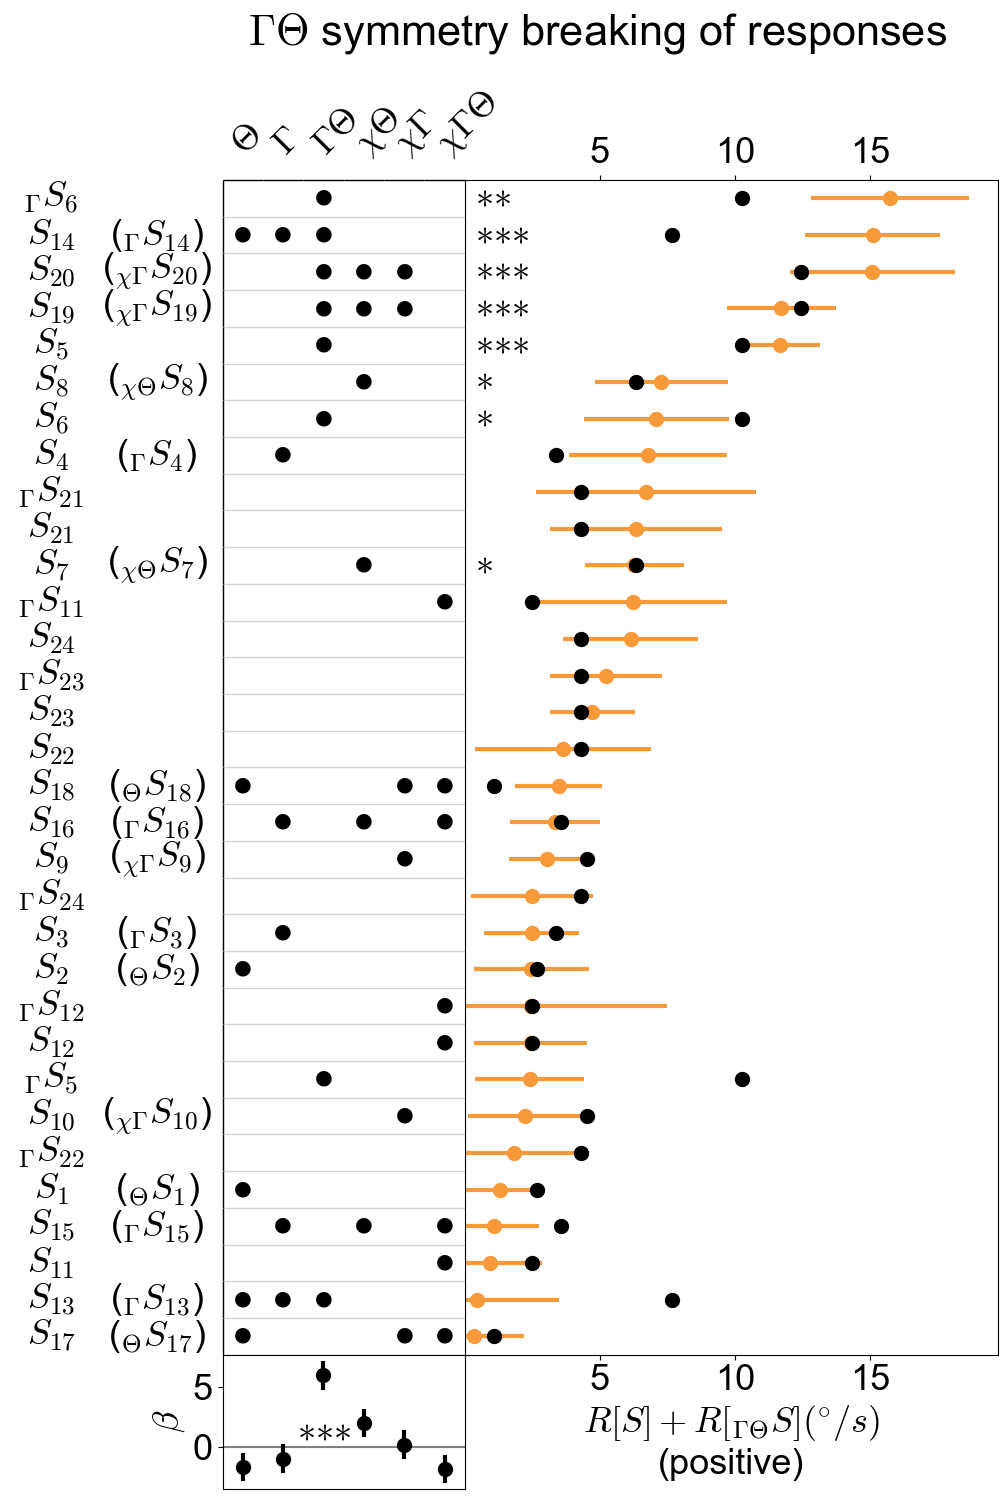

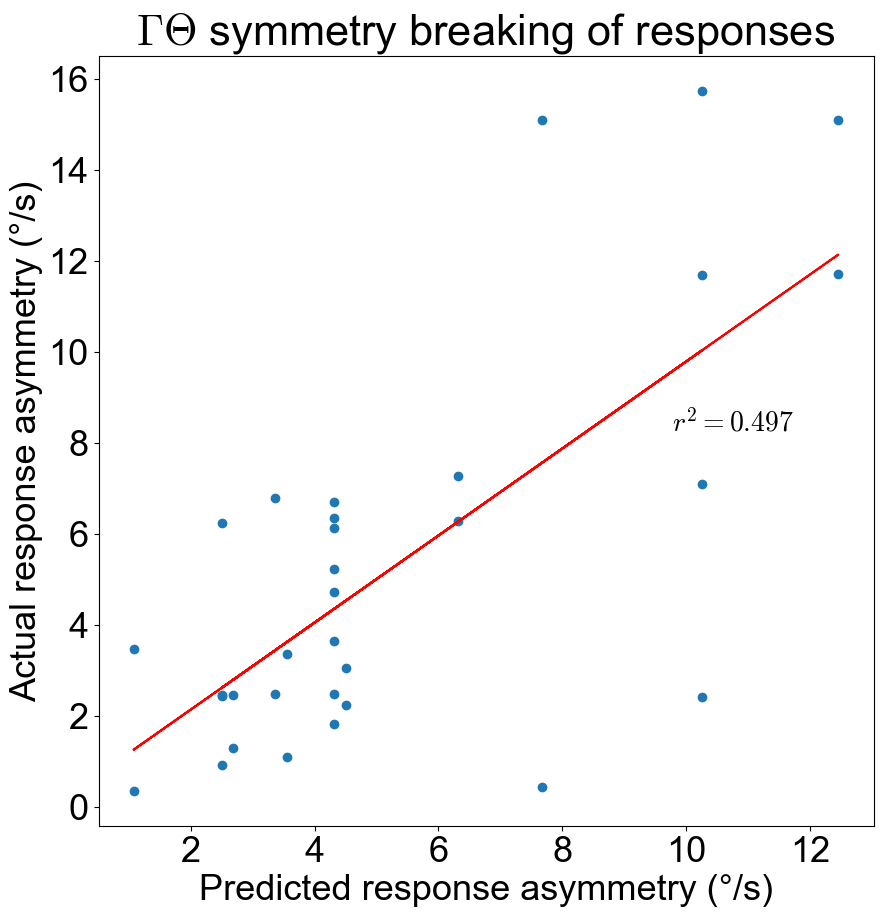

In [96]:
response_asymmetry_ols(t_flips_df, t_flip_ols_results_symmetry, '$\Theta$ symmetry breaking of responses', mode = 'symmetry', save_name = save_filepath + '/fig4/t_flips_symmetry_ols.pdf', color = "#E9484B")
response_asymmetry_ols(c_flips_df, c_flip_ols_results_symmetry, '$\Gamma$ symmetry breaking of responses', mode = 'symmetry', save_name = save_filepath + '/fig4/c_flips_symmetry_ols.pdf', color = "#72BF6F")
response_asymmetry_ols(ct_flips_df, ct_flip_ols_results_symmetry, '$\Gamma\Theta$ symmetry breaking of responses', mode = 'symmetry', save_name = save_filepath + '/fig4/ct_flips_symmetry_ols.pdf', color = "#F8993A")

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


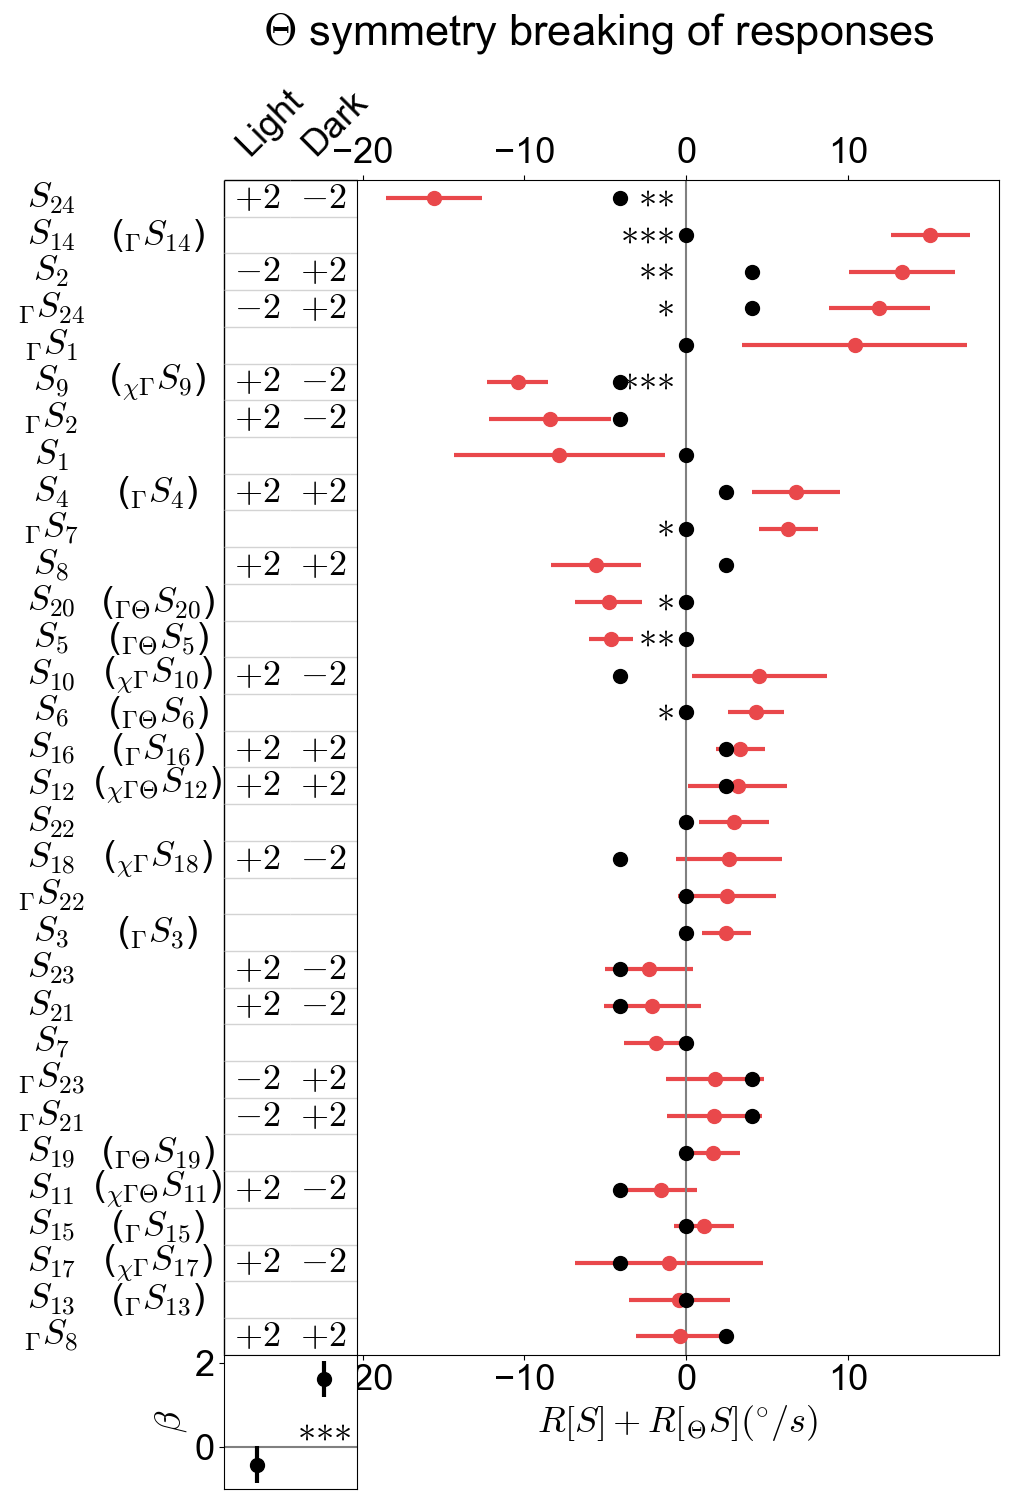

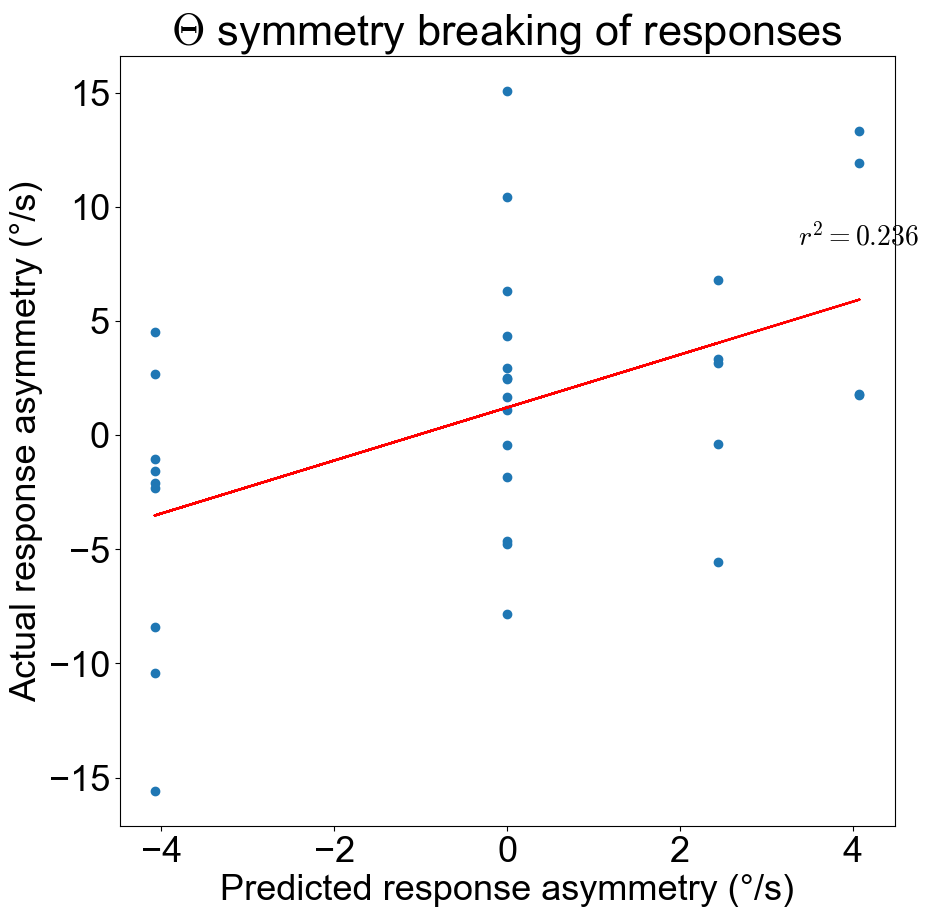

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


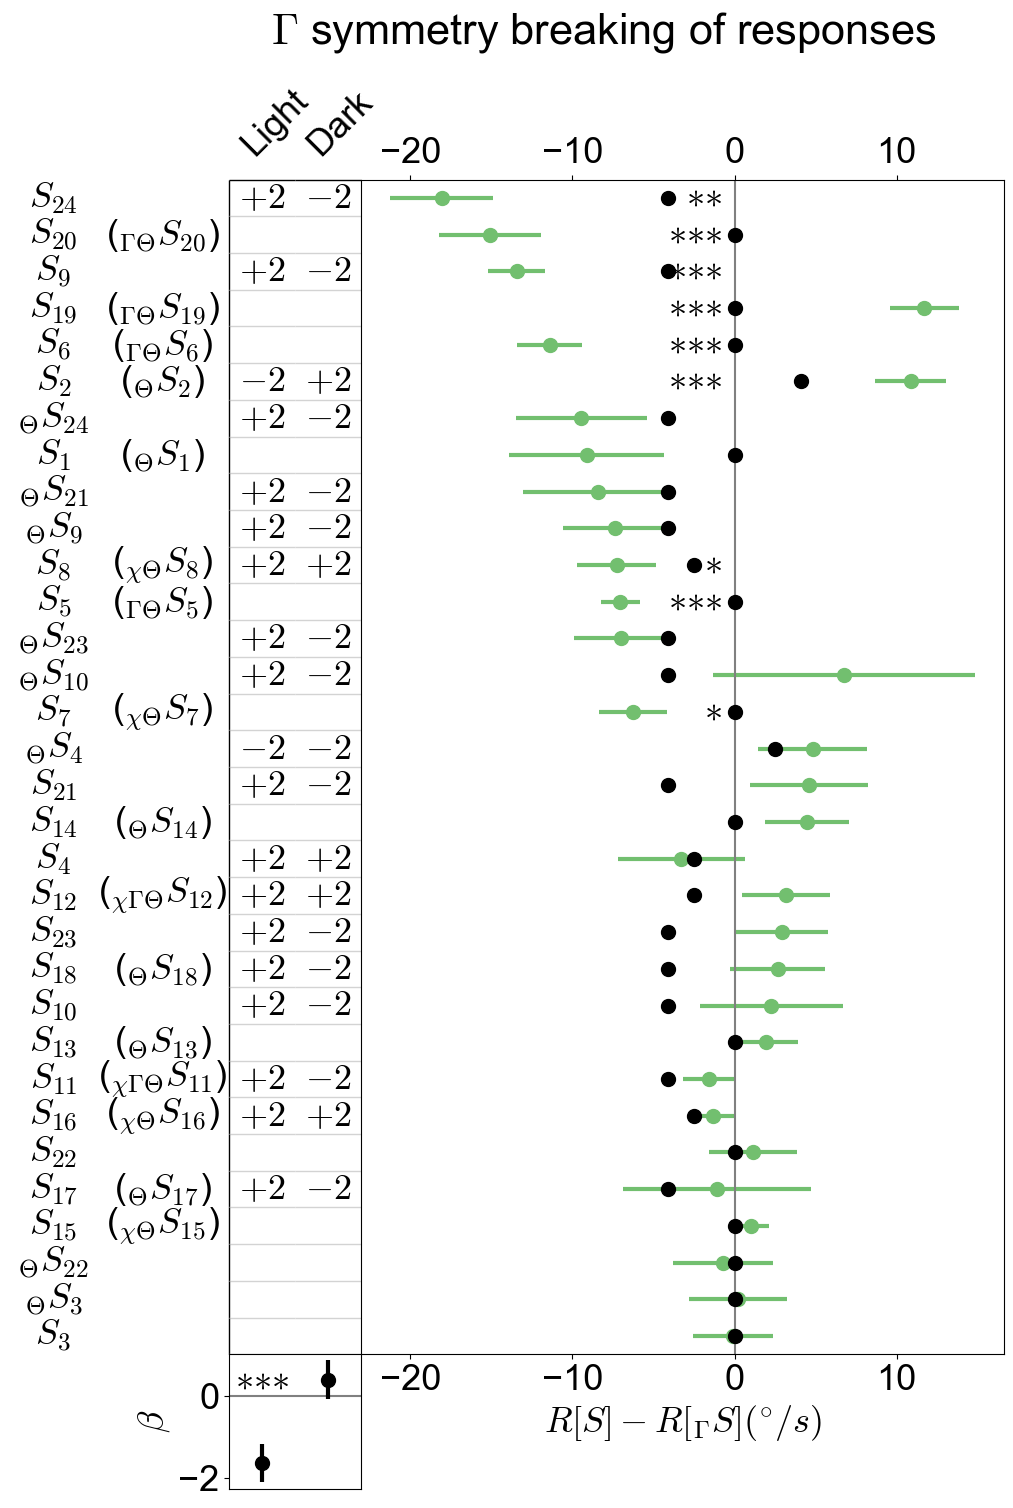

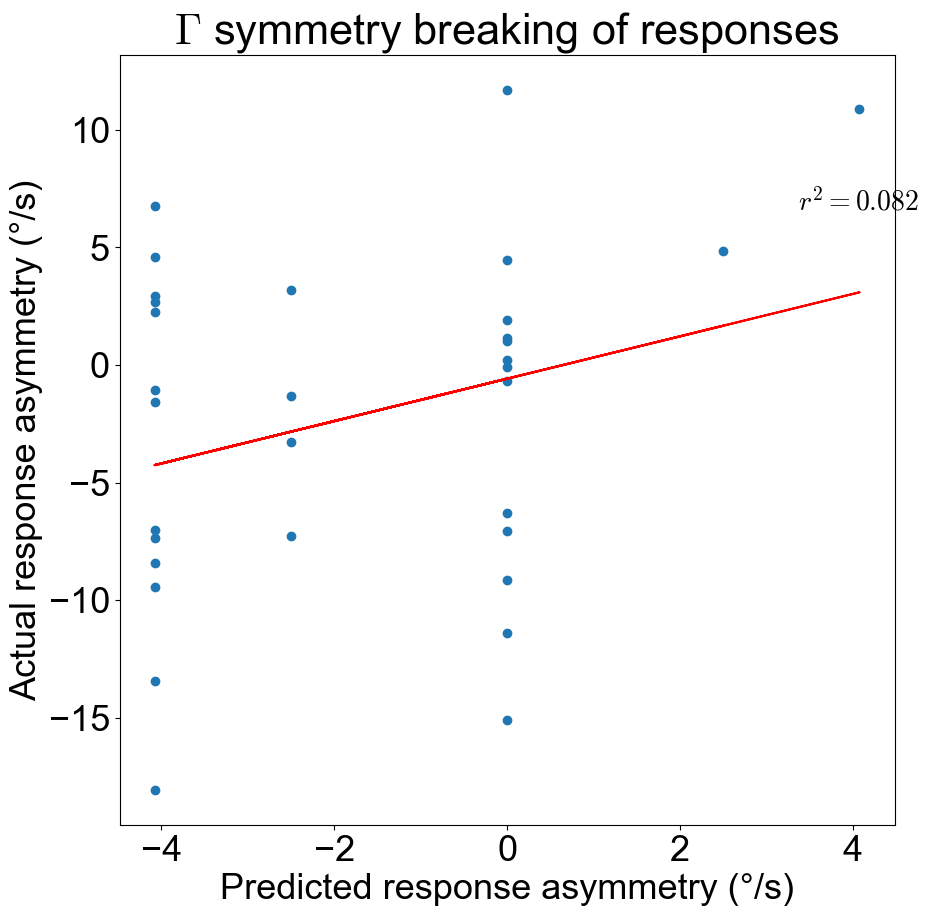

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


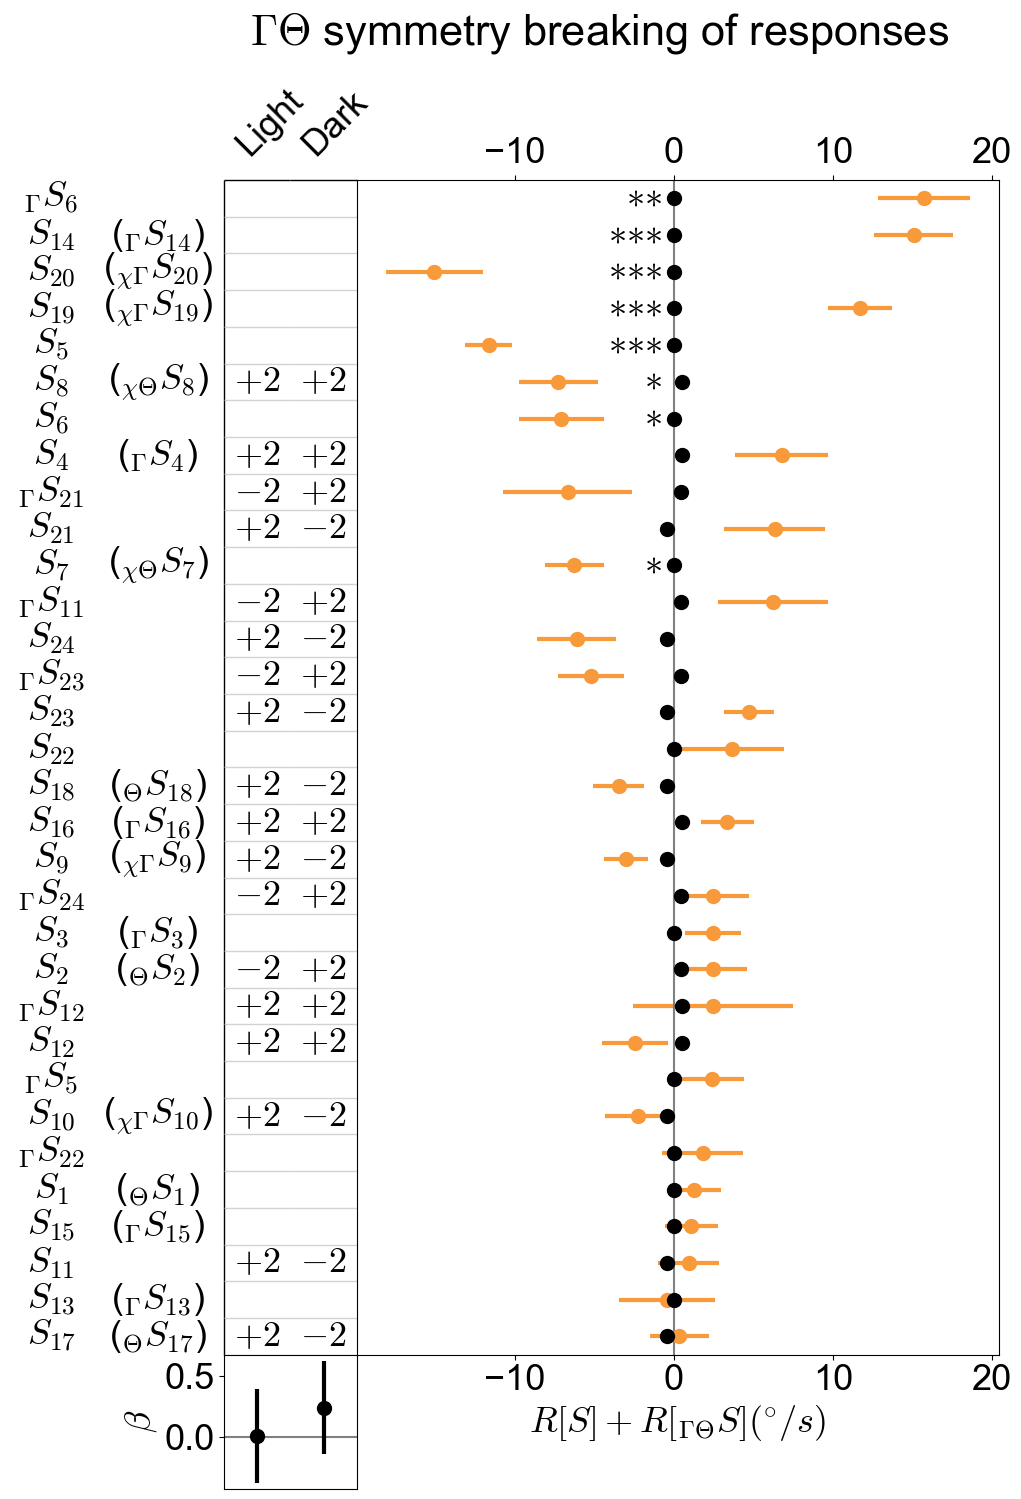

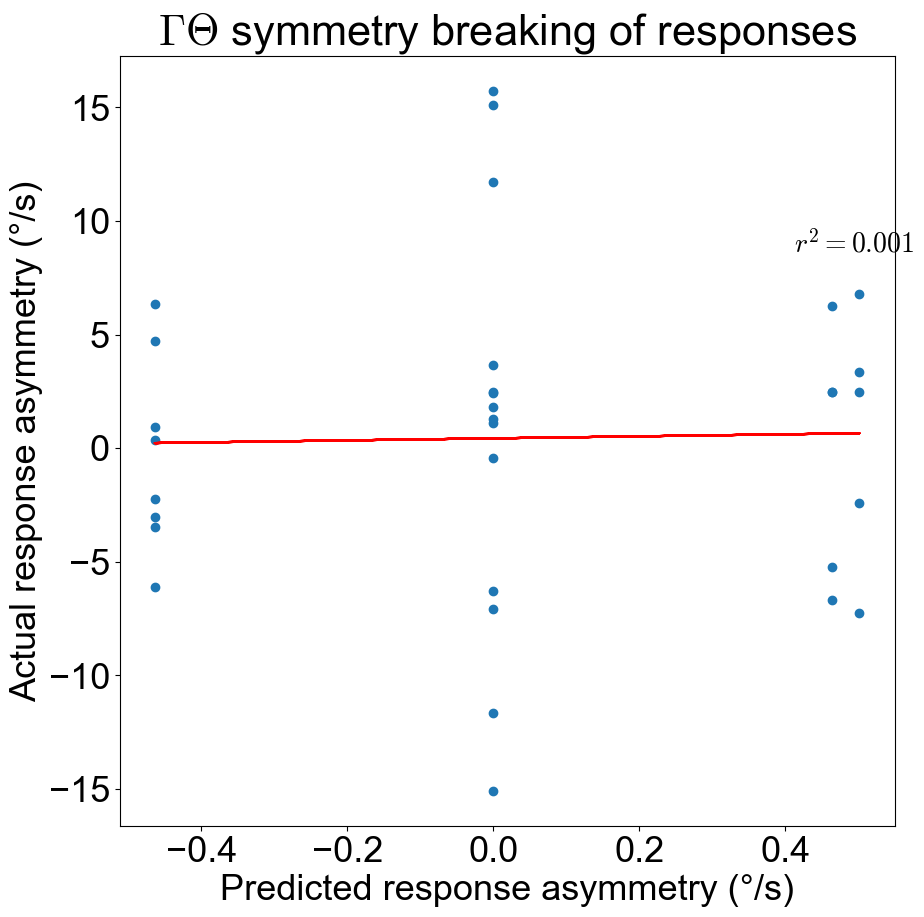

In [97]:
#https://stackoverflow.com/questions/57168268/matplotlib-table-y-axis-alignment-to-chart
#t flips


response_asymmetry_ols(t_flips_df, t_flip_ols_results_edges, '$\Theta$ symmetry breaking of responses', mode = 'edges', save_name = save_filepath + 'fig4/t_flips_edges_ols.pdf', color = "#E9484B")
response_asymmetry_ols(c_flips_df, c_flip_ols_results_edges, '$\Gamma$ symmetry breaking of responses', mode = 'edges', save_name = save_filepath + '/fig4/c_flips_edges_ols.pdf',color = "#72BF6F")
response_asymmetry_ols(ct_flips_df, ct_flip_ols_results_edges, '$\Gamma\Theta$ symmetry breaking of responses', mode = 'edges', save_name = save_filepath + '/fig4/ct_flips_edges_ols.pdf', color = "#F8993A")

In [179]:
#https://stackoverflow.com/questions/57168268/matplotlib-table-y-axis-alignment-to-chart
def build_summary_plot(full_flips_df, edges_ols_results, symmetries_ols_results, title, save_name = None, color = "r", equations = False):
    plt.rcParams.update({'font.size': 26})


    inner_edge_color = 'lightgray'

    def format_base(stimulus_id, base, mode = "base"):
        if base == 'S':
            formatted_base = '$S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_c': 
            formatted_base = '$_{\Gamma}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_t': 
            formatted_base = '$_{\Theta}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_ct': 
            formatted_base = '$_{\Gamma\Theta}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_xt': 
            formatted_base = '$_{\chi\Theta}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_xc': 
            formatted_base = '$_{\chi\Gamma}S_{' + str(int(stimulus_id)) + '}$'
        elif base == 'S_xct': 
            formatted_base = '$_{\chi\Gamma\Theta}S_{' + str(int(stimulus_id)) + '}$'
        else:
            return ""

        if mode != "base":
            formatted_base = "(" + formatted_base + ") "

        return formatted_base

    
    table_width = 1
    extra_factor = 0.75
    buffer = 0.15

    space_2 = 0.6
    if equations == True:
        space_2 = 1

    fig = plt.figure(figsize = (14, 18))
    ax_dict = fig.subplot_mosaic(
        """
        .......AA
        .........
        .......BB
        .........
        DDDDDD..F
        .........
        CCCCCC..E
        """,
        width_ratios = [(table_width - buffer)*(1/6)]* 6 + [buffer, buffer, 1 - buffer],
        height_ratios= [1, 
                        0.4, 
                        1, 
                        space_2, 
                        0.8,
                        0.5,
                        1.4, 
        ]
    )
    ax_dict['B'].sharex(ax_dict['A'])


    plt.suptitle(title)

    for ax_num, indices in enumerate([range(0, 5), range(19, 24)]):
        flips_df = full_flips_df.iloc[indices].reset_index()
        axes_names = ['A', 'B']
        ax = ax_dict[axes_names[ax_num]]

        ax.errorbar(flips_df['mean'], flips_df.index, xerr = flips_df['sem'], fmt = "o", c = color, markersize = 10, linewidth = 3)

        #plt.yticks(flips_df.index, ((stimulus_df.loc[flips_df['stimulus id'][i], 'Stimulus type'] + ', ' + flips_df['stimulus combination'][i]) for i in flips_df.index), rotation = 'horizontal')
        ax.set_yticks([], [])
        ax.tick_params(axis='both', labelsize=22)


        for i in flips_df.index:
            #significance stars while we're at it
            if flips_df['pval_corrected'][i] < 0.001:
                ax.text(0, i, ' $*$$*$$*$  ', va = 'center', ha = 'right', c = 'k', rotation = 'horizontal' )
            elif flips_df['pval_corrected'][i] < 0.01:
                ax.text(0, i, ' $*$$*$  ', va = 'center', ha = 'right', c = 'k', rotation = 'horizontal' )
            elif flips_df['pval_corrected'][i] < 0.05:
                ax.text(0, i, ' $*$  ', va = 'center', ha = 'right', c = 'k', rotation = 'horizontal' )
        ax.margins(y=0)

        #get x label
        if flips_df.loc[0, 'combination'] == 'S+S_t':
            x_label = 'R[S]+R[_{\Theta}S]'
        elif flips_df.loc[0, 'combination'] == 'S-S_c':
            x_label = 'R[S]-R[_{\Gamma}S]'
        elif flips_df.loc[0, 'combination'] == 'S+S_ct':
            x_label = 'R[S]+R[_{\Gamma\Theta}S]'

        
        ax.set_xlabel('$' + x_label + '$ $(^{\circ}/s)$')
        ax.set_ylim(-0.5, len(flips_df) - 0.5)
        #significance stars
        ax.vlines(0, -0.5, len(flips_df)- 0.5, colors = 'grey', linewidths = 2, zorder = 0)



        #print(prediction_results[0].summary_frame())
        #ax.errorbar([flips_df.loc[i, ols_predictions_colname] for i in flips_df.index], flips_df.index, c = 'k', fmt = "o", markersize = 10, linewidth = 3)



        # if mode == 'symmetry':
        #     rows = ['T', 'C', 'CT', 'XT', 'XC', 'XCT']
        # elif mode == 'edges':
        #     rows = ['net light', 'net dark']
        symmetry_rows = ['T', 'C', 'CT', 'XT', 'XC', 'XCT']
        edges_rows = ['net light', 'net dark']
        

        base_labels = [format_base(flips_df['stimulus id'][i], flips_df['base'][i]) for i in flips_df.index]
        secondary_labels = [[format_base(flips_df['stimulus id'][i], flips_df['secondary'][i], mode = "secondary")] for i in flips_df.index]

        symmetry_int_values = flips_df[symmetry_rows].values.astype(int)
        edges_int_values = flips_df[edges_rows].values.astype(int)

        #if mode == 'symmetry':
        table_values = [0] * len(symmetry_int_values)
        symmetry_table_values = [['' if cell == 0 else '●' for cell in row] for row in symmetry_int_values]
        #elif mode == 'edges':
        def get_string(num):
            if num == 0:
                return ''
            elif num == 2:
                #return '+'
                return '$+2$'
            elif num == -2:
                #return '-'
                return '$-2$'
        edges_table_values = [[get_string(cell) for cell in row] for row in edges_int_values]
        
        for i in range(0, len(table_values)):
            table_values[i] = secondary_labels[i] + edges_table_values[i] + symmetry_table_values[i]

        

        #elif mode == 'edges':
        col_labels = ["", 'Light', 'Dark', 
            '$\Theta$',
            '$\Gamma$',
            '$\Gamma\Theta$',
            '$\chi\Theta$',
            '$\chi\Gamma$',
            '$\chi\Gamma\Theta$']
        
        if ax_num == 1:
            col_labels = [""] * len(col_labels)
        
        table = ax.table(cellText=table_values,
                            #cellColours=colors,
                            #rowLabels=[(stimulus_df.loc[flips_df['stimulus id'][i], 'Stimulus type'] + ', ' + flips_df['stimulus combination'][i]) for i in flips_df.index[::-1]],
                            #colLabels=[('S_' + str(flips_df['stimulus id'][i]) + ', ' + flips_df['stimulus combination'][i]) for i in flips_df.index[::1]],
                            #rowHeights=[0.1 for x in rows],
                            colWidths = [1 - extra_factor] + [extra_factor * 1.5/(len(col_labels) - 1)] * 2 + [extra_factor/(len(col_labels) - 1)] * 6,
                            colLabels=col_labels,
                            rowLabels = base_labels,
                            cellLoc='center',
                            rowLoc = 'center',
                            loc = 'left',
                            bbox = (-1 * table_width, 0, table_width, 1 + 1/len(flips_df)),
                            edges = '',
        )

        for cell_id in table._cells:
            #table._cells[cell_id].set(edgecolor = 'grey')
            visible_edges = "B"

            table._cells[cell_id].set(edgecolor = inner_edge_color, linewidth = 2)
            #table._cells[cell_id].set(edgecolor = "k")

            if cell_id[1] == 2:
                visible_edges += 'R'
            if cell_id[1] == 3:
                visible_edges += 'L'
            #if cell_id[0] == len(table_values):
            #    visible_edges += 'B'

            if cell_id[0] == 0 and cell_id[1] > 0:
                table._cells[cell_id].set(edgecolor = "k")
                visible_edges = 'B'
            if cell_id[1] == 0:
                table._cells[cell_id].set(edgecolor = "k")
                visible_edges = 'R'
            if cell_id[1] ==-1:
                visible_edges = ''
            if cell_id[0] == 0 and cell_id[1] == 0:
                visible_edges = ''

            if cell_id[0] >= len(table_values):
                table._cells[cell_id].set(edgecolor = "k")


            if cell_id[1] >= 1 and cell_id[0] >= 1:
                table._cells[cell_id].set_text_props(fontsize = 26)

            if cell_id[0] == 0:            
                table._cells[cell_id].set_text_props(rotation = 45)
                
                #table._cells[cell_id].set_text_props(rotation_mode = 'anchor')
                table._cells[cell_id].set_text_props(va = 'bottom')
                table._cells[cell_id].set_text_props(ha = 'left')
                #table._cells[cell_id].visible_edges = 'R'




            table._cells[cell_id].visible_edges = visible_edges       



        table.auto_set_font_size(False)

        #table.auto_set_column_width(col = list(range(len(modified_stimulus_df.columns))))

        ax.invert_yaxis()

        if ax_num == 0:
            ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
            ax.xaxis.set_label_position('top') # THIS IS THE ONLY CHANGE
        elif ax_num == 1:
            ax.tick_params(top = False, labeltop = False, bottom = True, labelbottom = True)
        

        #ax.spines["right"].set_visible(False)
        #ax.spines["top"].set_visible(False)
        #ax.spines["bottom"].set_visible(True)
        #ax.spines["left"].set_visible(True)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(2)
        ax.spines["right"].set_linewidth(2)
        ax.spines["top"].set_linewidth(2)
        ax.tick_params(direction='in', length=4, width=2, labelsize=20)
        ax.minorticks_off()


    plt.subplots_adjust(wspace=0, hspace=0, top = 0.82)






    for mode in ["edges", "symmetry"]:
        if mode == 'symmetry':
            rows = ['T', 'C', 'CT', 'XT', 'XC', 'XCT', 'const']
            row_labels = ['$\\beta_{\Theta}$', '$\\beta_{\Gamma}$', '$\\beta_{\Gamma\Theta}$', '$\\beta_{\chi\Theta}$', '$\\beta_{\chi\Gamma}$', '$\\beta_{\chi\Gamma\Theta}$', '$b$']
            ols_results = symmetries_ols_results
            ols_predictions_colname = 'predicted symmetries ols mean'
            mean_type = 'mean_abs'
            ax_names = ['E', 'F']
            #ax_title =  '$\widehat{\\mid y \\mid}= \\beta_{' + '\Theta}+ \\beta_{' + '\Gamma}+ \\beta_{' + '\Gamma\Theta}+ \\beta_{' + '\chi\Theta}+\\beta_{' + '\chi\Gamma} + \\beta_{' + '\chi\Gamma\Theta} + b$\n'
            ax_title =  '$\hat{y}_{pos}= b + \sum_{i \in \{\Theta, \cdots, \chi\Gamma\Theta\}}\\beta_i \cdot B_i$'
            x_label = '$\hat{y}_{pos}$ $(^{\circ}/s)$'
            y_label = '$y_{pos}$ $(^{\circ}/s)$'
        elif mode == 'edges':
            rows = ["net light", "net dark"]
            row_labels = [r'$\beta_{light}$', r'$\beta_{dark}$']
            ols_results = edges_ols_results
            ols_predictions_colname = 'predicted edges ols mean'
            mean_type = 'mean'
            ax_names = ['C', 'D']
            ax_title = '$\widehat{y} = \\beta_{light} \cdot C_{light} + \\beta_{dark} \cdot C_{dark}$\n'
            x_label = '$\widehat{y}$ $(^{\circ}/s)$'
            y_label = '$y$ $(^{\circ}/s)$'

        ax = ax_dict[ax_names[1]]

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(True)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(2)
        ax.tick_params(direction='in', length=4, width=2, labelsize=20)
        ax.tick_params(axis='x', labelsize=22)

        ax.minorticks_off()


        #ax.tick_params(axis='both', labelsize=22)
        #ax.set_xticks([], [])
        #ax.set_xlim([-8, 8])
        ax.set_xticks(0.5 + np.arange(0, len(rows)), row_labels)
        ax.set_xlim([0, len(rows)])
        ax.margins(x = 0)
        #ax.set_ylabel(r'$ \beta $')

        ax.hlines(0, 0, len(rows), colors = 'grey', linewidths = 2)


        ax.errorbar(np.arange(0, len(rows)) + 0.5, ols_results.params[rows], yerr = ols_results.bse[rows].values.reshape(-1), fmt ="o", c = 'k', markersize = 10, linewidth = 3)
        p_values = ols_results.pvalues[rows]

        for i, symmetry in enumerate(p_values.index):

            if p_values[symmetry] < 0.001:
                ax.text( i + 0.5, 0, '$*$$*$$*$', va = 'bottom', ha = 'center', c = 'k', rotation = 'horizontal')
            elif p_values[symmetry] < 0.01:
                ax.text( i + 0.5, 0, '$*$$*$', va = 'bottom', ha = 'center', c = 'k', rotation = 'horizontal')
            elif p_values[symmetry] < 0.05:
                ax.text( i + 0.5, 0, '$*$', va = 'bottom', ha = 'center', c = 'k', rotation = 'horizontal')
            # if flips_df['p corrected'][i] < 0.001:
            #     ax.text(i+0.2, -0.3, '***', ha = 'center', va = 'top', c = 'r', rotation = 'vertical')
            # elif flips_df['p corrected'][i] < 0.01:
            #     ax.text(i+0.2, -0.3, '**', ha = 'center', va = 'top', c = 'r', rotation = 'vertical')
            # elif flips_df['p corrected'][i] < 0.05:
            #     ax.text(i+0.2, -0.3, '*',  ha = 'center', va = 'top', c = 'r', rotation = 'vertical')

        if equations:
            ax.set_title(ax_title, fontsize = 22)


        ax = ax_dict[ax_names[0]]
        plt.sca(ax)


        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(True)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(2)
        ax.tick_params(direction='in', length=4, width=2, labelsize=20)
        ax.minorticks_off()

        
        #ax.tick_params(axis='both', labelsize=22)
        plt.scatter(full_flips_df[ols_predictions_colname], full_flips_df[mean_type], c = "k")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        linreg = linregress(full_flips_df[ols_predictions_colname], full_flips_df[mean_type])
        plt.plot(full_flips_df[ols_predictions_colname], linreg.intercept + linreg.slope * full_flips_df[ols_predictions_colname], "-", c = color, linewidth = 3)
        plt.text(plt.xlim()[0], plt.ylim()[1] * 1/2, f' $r^2 = {linreg.rvalue**2:.3f}$', fontsize = 26)

        xlims = list(plt.xlim())
        ylims = list(plt.ylim())

        if mode == "symmetry":
            xlims[0] = 0
            ylims[0] = 0

        plt.xlim(xlims)
        plt.ylim(ylims)

        ax.hlines(0, plt.xlim()[0], plt.xlim()[1], colors = 'grey', zorder = 0, linewidths = 2)
        ax.vlines(0, plt.ylim()[0], plt.ylim()[1], colors = 'grey', zorder = 0, linewidths = 2)



    
    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight')
    

    plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


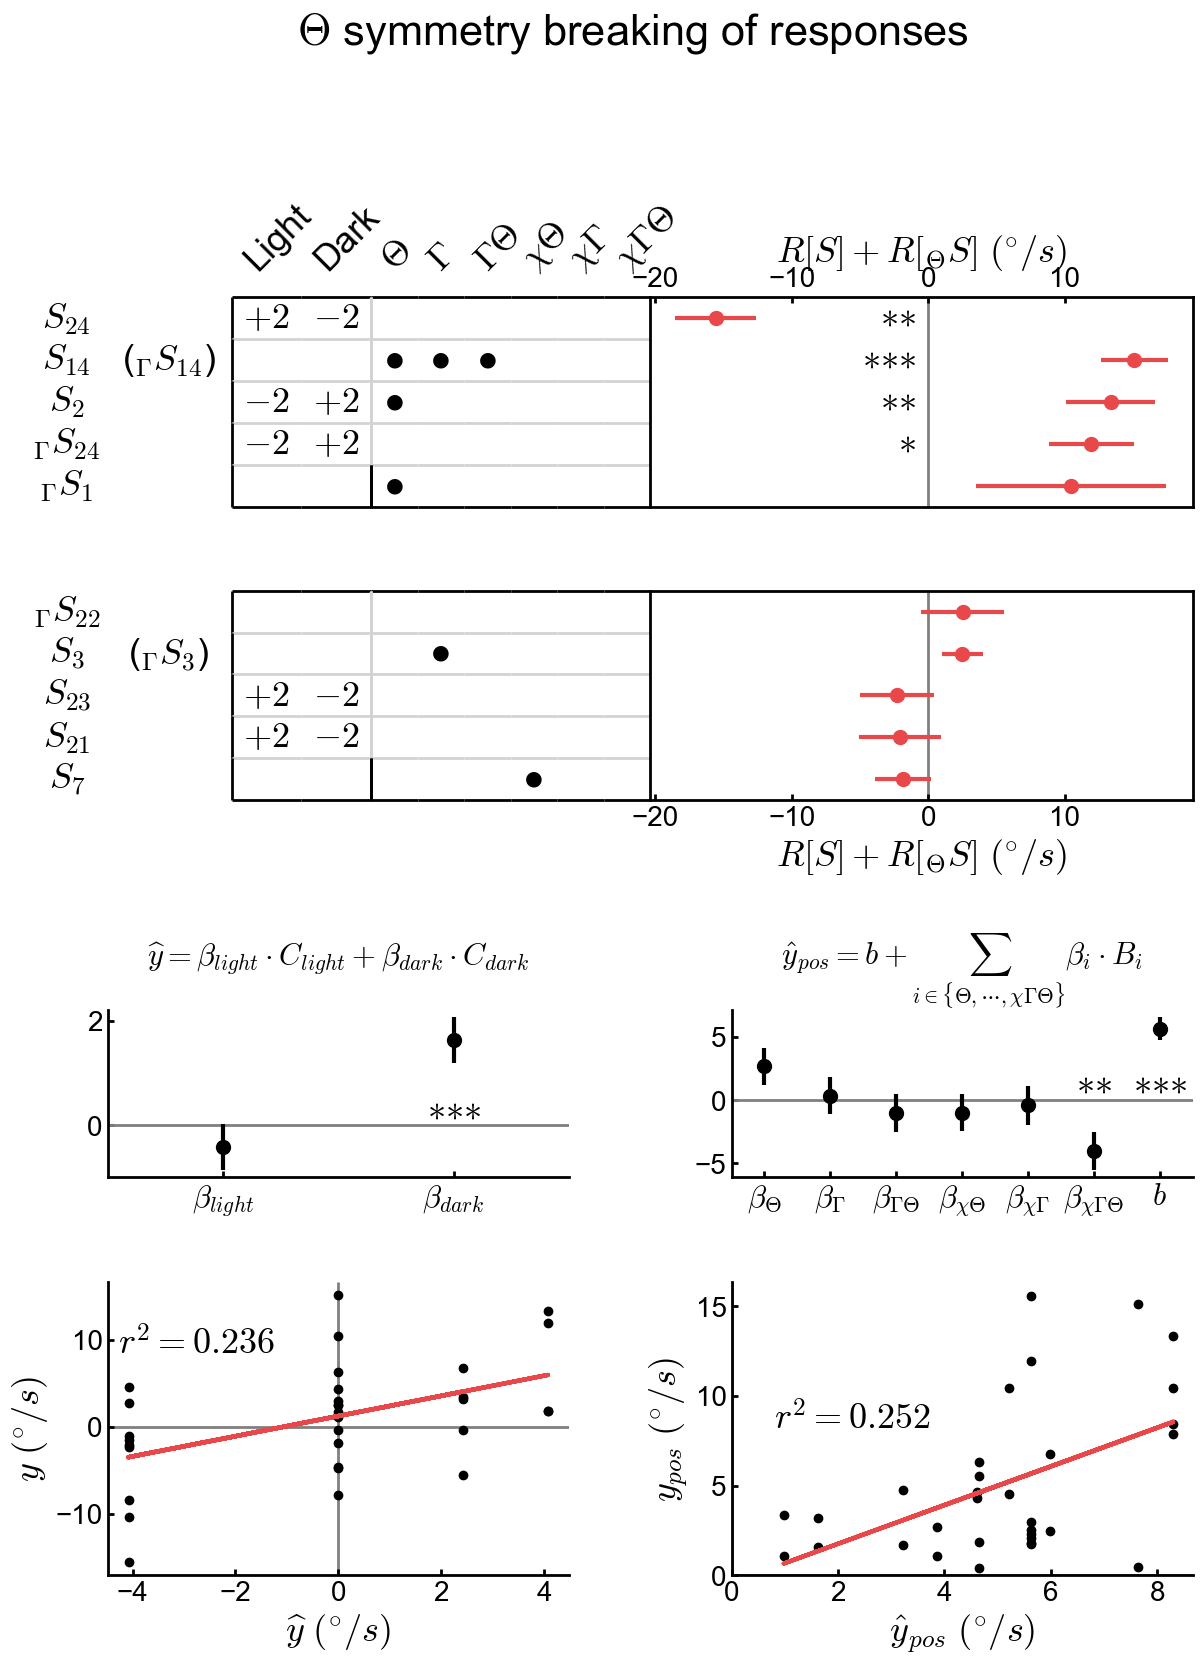

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


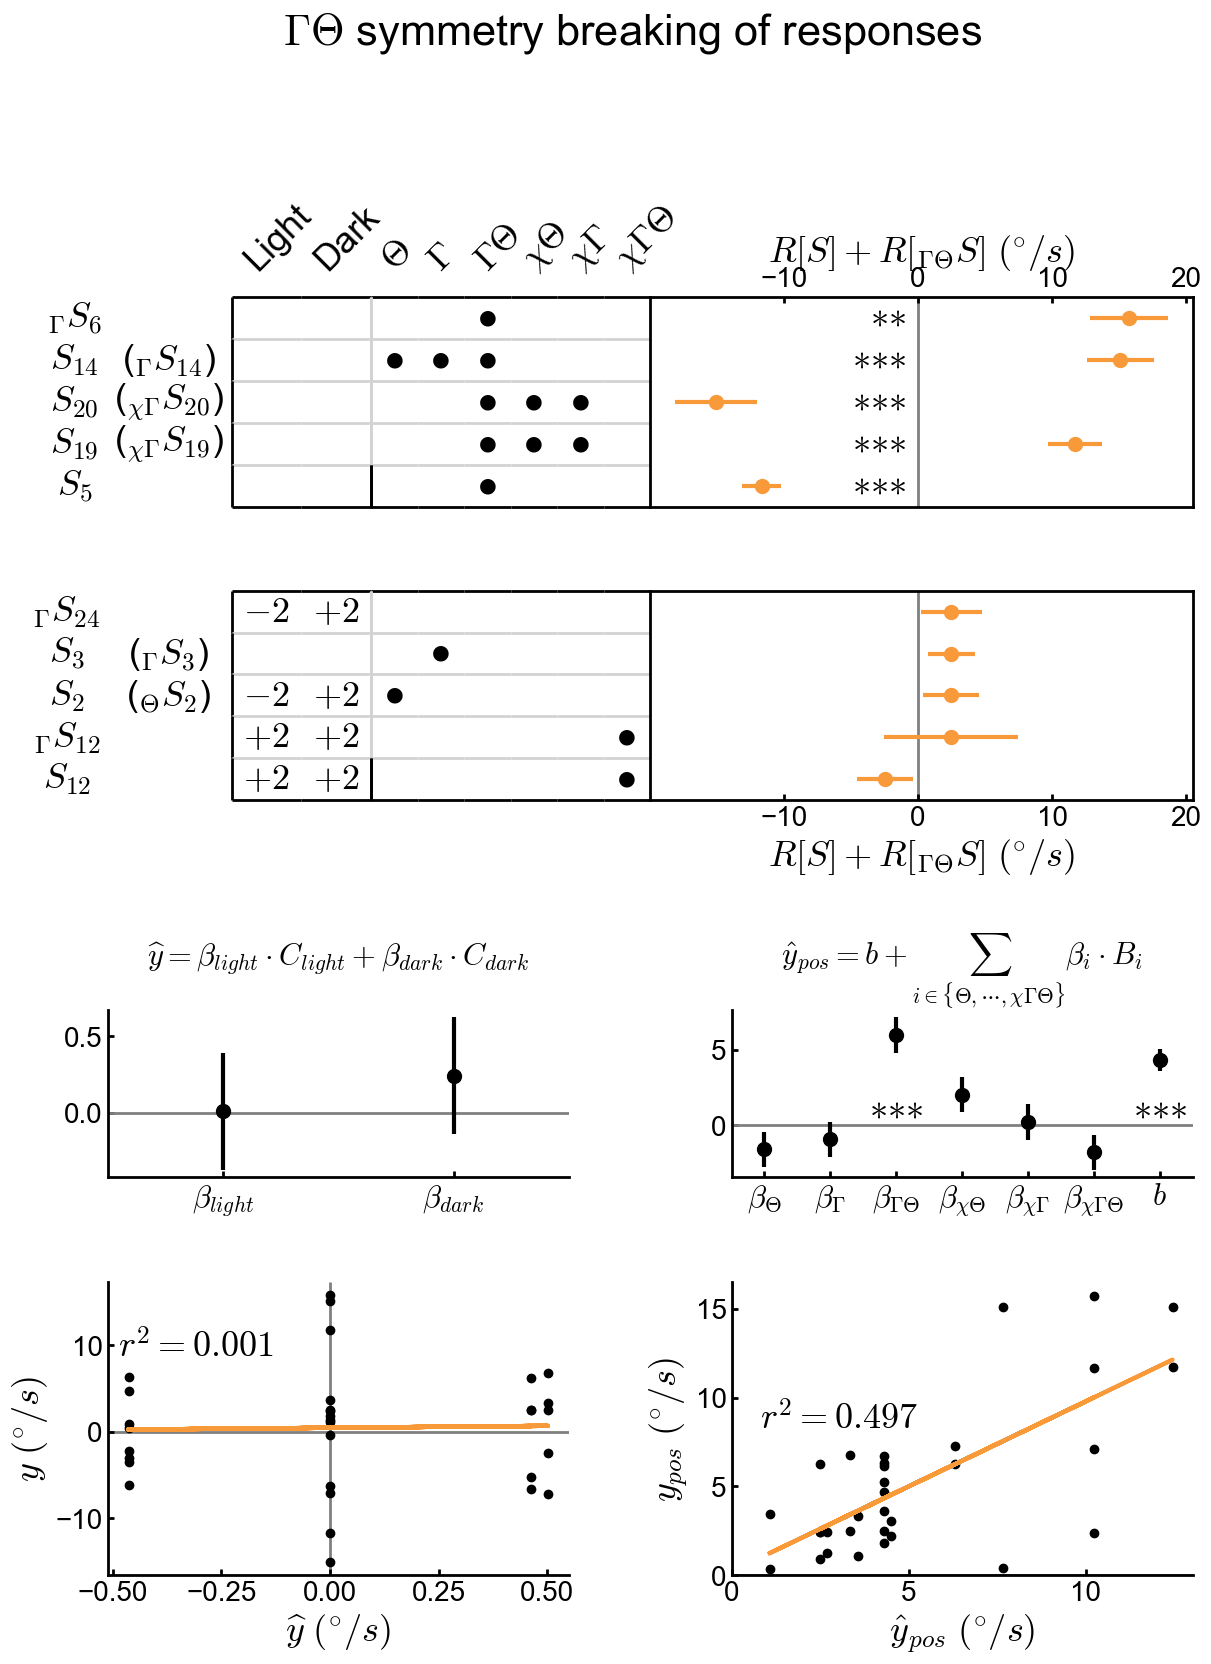

In [180]:
build_summary_plot(t_flips_df, t_flip_ols_results_edges, t_flip_ols_results_symmetry, '$\Theta$ symmetry breaking of responses', save_name = save_filepath + 'fig4/summary_plot_t_flips_v2.pdf', color = "#E9484B", equations = True)
build_summary_plot(ct_flips_df, ct_flip_ols_results_edges, ct_flip_ols_results_symmetry, '$\Gamma\Theta$ symmetry breaking of responses', save_name = save_filepath + 'fig4/summary_plot_ct_flips_v2.pdf', color = "#F8993A", equations = True)

